#**Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [5]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [6]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170498071/170498071 [==============================] - 5s 0us/step


###Plot functions

In [7]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

In [8]:
def plot_function(x,y,data,stop = 0):
  plt.figure(figsize=(10,6))
  if data == "train":
    if stop != 0: 
      plt.semilogy(x[:stop], y[:stop], label='MSE Train',  color = "orange")
      ticks = range(0,max(x[:stop])+100,100)
    else: 
      plt.semilogy(x , y, label='MSE Test', color = "orange")
      ticks = range(0,max(x)+100,100)
    plt.title("Train MSE")

  if data == "test":
    if stop != 0:
      plt.semilogy(x[:stop], y[:stop], label='MSE Test')
      ticks = range(0,max(x[:stop])+100,100)
    else:
      plt.semilogy(x , y, label='MSE Test')
      ticks = range(0,max(x)+100,100)
    plt.title("Test MSE")
  
  if data == "time":
    if stop != 0:
      plt.plot(x[:stop], y[:stop], label='Execution time')
      ticks = range(0,max(x[:stop])+100,100)
    else:
      plt.plot(x , y, label='Execution time')
      ticks = range(0,max(x)+100,100)
    plt.title("Execution time")

  ticks = list(ticks)
  ticks[0] = 10
  plt.xticks(ticks)
  plt.legend()

In [9]:
def plot_loss(history_1,history_2 = None, comparison = False):
  plt.figure(figsize=(10,6))
  if comparison == False:
    plt.plot(history_1.epoch,history_1.history['loss'])
    plt.plot(history_1.epoch,history_1.history['val_loss'])
  else:
    plt.semilogy(history_1.epoch,history_1.history['loss'], label = 'training loss 1')
    plt.semilogy(history_1.epoch,history_1.history['val_loss'], label = 'validation loss 1')
    plt.semilogy(history_2.epoch,history_2.history['loss'], label = 'training loss 2')
    plt.semilogy(history_2.epoch,history_2.history['val_loss'], label = 'validation loss 1')
  plt.legend()
  plt.grid()
  plt.title('loss')

## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [10]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [11]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [12]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [13]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

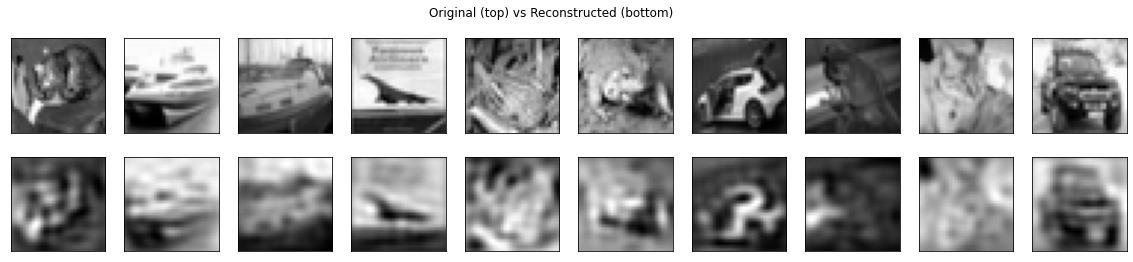

In [14]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

### Question

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

It is clear from theory and attempts above that as the encoding dimension gets lower the MSE increases since the SVD catches only the most important features of the picture; on the other hand if the encoding dimension increases then the MSE decreases and when the encoding dimension reaches the sample dimension the SVD just catches all the information without any filter. 

### Testing

#### Some plots with different encoding dimension

Iteration with encoding dim: 16
Training mse: 0.014066088944674
Test mse: 0.014149976894259


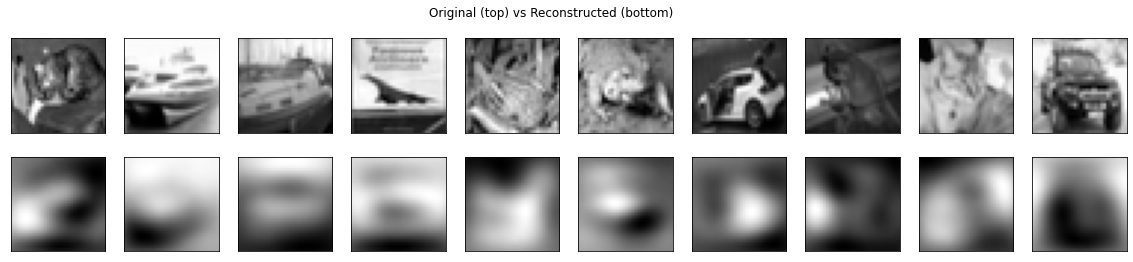

Iteration with encoding dim: 64
Training mse: 0.006282146554440
Test mse: 0.006312313955277


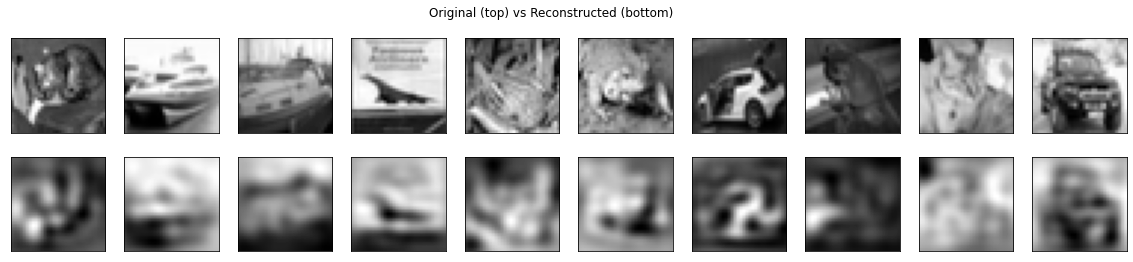

Iteration with encoding dim: 128
Training mse: 0.003491958603263
Test mse: 0.003526820801198


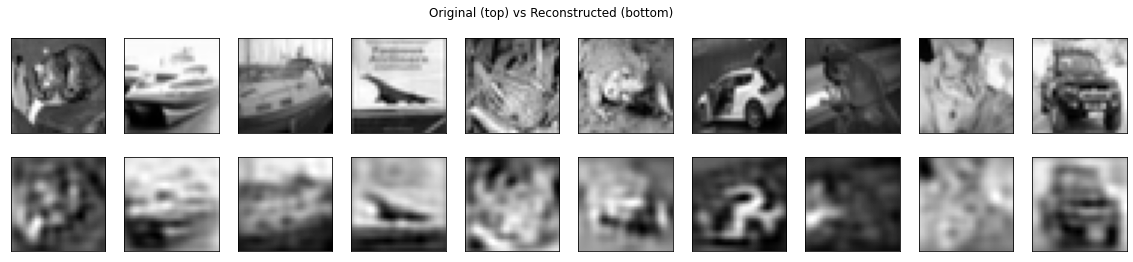

Iteration with encoding dim: 512
Training mse: 0.000367168919183
Test mse: 0.000383307575248


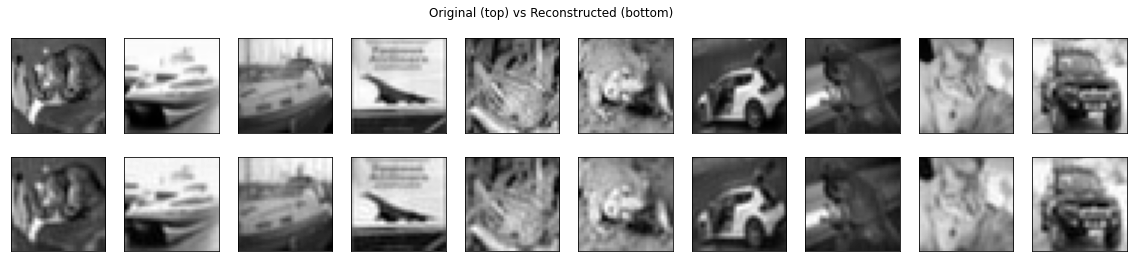

Iteration with encoding dim: 768
Training mse: 0.000070569032687
Test mse: 0.000075434567407


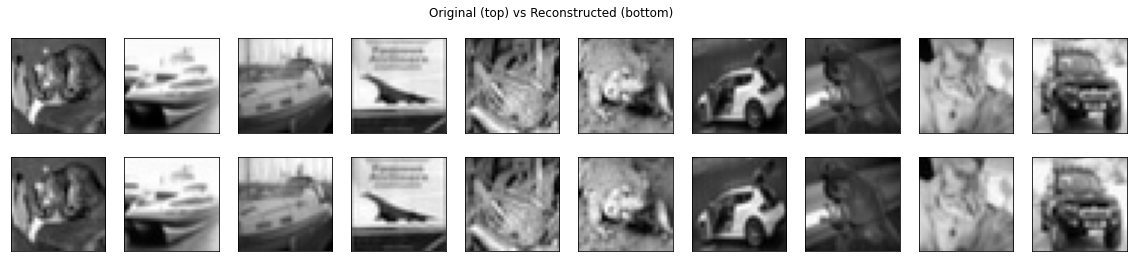

Iteration with encoding dim: 1024
Training mse: 0.000000000000110
Test mse: 0.000000000000112


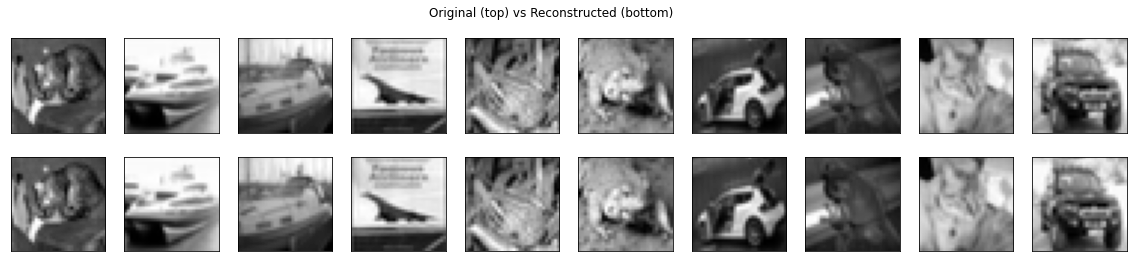

Iteration with encoding dim: 1500
Training mse: 0.000000000000110
Test mse: 0.000000000000112


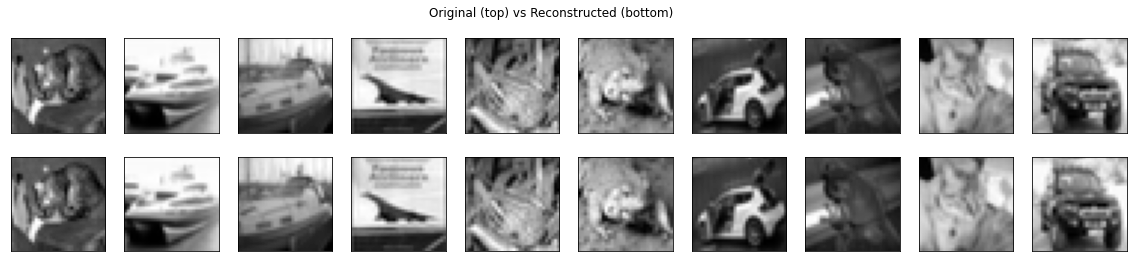

Iteration with encoding dim: 2000
Training mse: 0.000000000000110
Test mse: 0.000000000000112


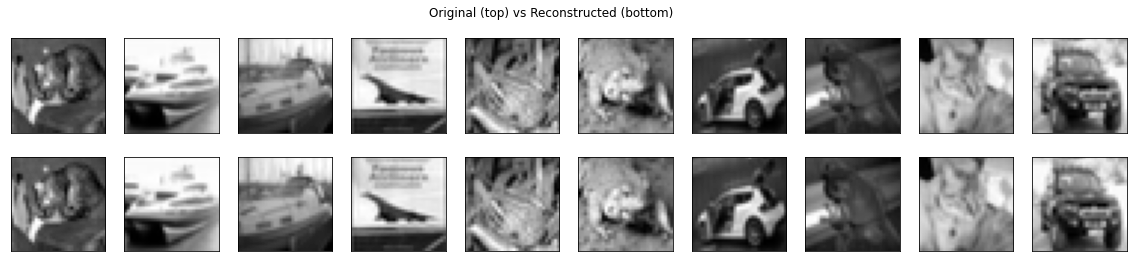

In [ ]:
encoding_list = [16,64,128,512,768,1024,1500,2000]

for ENCODING_DIM in encoding_list:
  U_k = SVD(x_train, ENCODING_DIM)
  x_training_svd = np.dot(x_train, U_k)
  x_test_svd = np.dot(x_test, U_k)
  x_training_reco = np.dot(x_training_svd, U_k.T)
  x_test_reco = np.dot(x_test_svd, U_k.T)
  accuracy_train = ((x_train - x_training_reco)**2).mean()
  accuracy_test = ((x_test - x_test_reco)**2).mean()
  print("Iteration with encoding dim: {}".format(ENCODING_DIM))
  print("Training mse: %.15f" % ( accuracy_train))
  print("Test mse: %.15f" % ( accuracy_test))
  plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

#### Testing for many different encoding dimension

In [ ]:
mse_test_list_svd = []
mse_train_list_svd = []
duration_list_svd = []
encoding_list = list(range(10, 1500, 20))

for ENCODING_DIM in encoding_list:
  start = time.time()
  U_k = SVD(x_train, ENCODING_DIM)
  x_training_svd = np.dot(x_train, U_k)
  x_test_svd = np.dot(x_test, U_k)
  x_training_reco = np.dot(x_training_svd, U_k.T)
  x_test_reco = np.dot(x_test_svd, U_k.T)
  accuracy_train = ((x_train - x_training_reco)**2).mean()
  accuracy_test = ((x_test - x_test_reco)**2).mean()
  mse_train_list_svd.append(accuracy_train)
  mse_test_list_svd.append(accuracy_test)
  print("Iteration with encoding dim: {}".format(ENCODING_DIM))
  print("Train mse: %.15f" % ( accuracy_train))
  print("Test mse: %.15f" % (accuracy_test ))
  end = time.time()
  execution_time = end - start
  duration_list_svd.append(execution_time)
  print("Execution time: %.3f" %(execution_time))

Iteration with encoding dim: 10
Train mse: 0.017500560730696
Test mse: 0.017605667933822
Execution time: 1.595
Iteration with encoding dim: 30
Train mse: 0.010166060179472
Test mse: 0.010210374370217
Execution time: 1.636
Iteration with encoding dim: 50
Train mse: 0.007459759712219
Test mse: 0.007498448248953
Execution time: 1.620
Iteration with encoding dim: 70
Train mse: 0.005883237812668
Test mse: 0.005914973095059
Execution time: 1.698
Iteration with encoding dim: 90
Train mse: 0.004818696528673
Test mse: 0.004846643656492
Execution time: 1.677
Iteration with encoding dim: 110
Train mse: 0.004037940409034
Test mse: 0.004067522007972
Execution time: 1.707
Iteration with encoding dim: 130
Train mse: 0.003438028274104
Test mse: 0.003473085351288
Execution time: 1.727
Iteration with encoding dim: 150
Train mse: 0.002961601596326
Test mse: 0.002996132941917
Execution time: 1.816
Iteration with encoding dim: 170
Train mse: 0.002573561388999
Test mse: 0.002609848976135
Execution time: 1.8

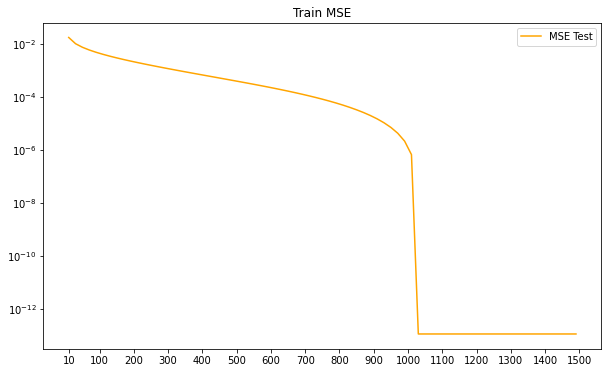

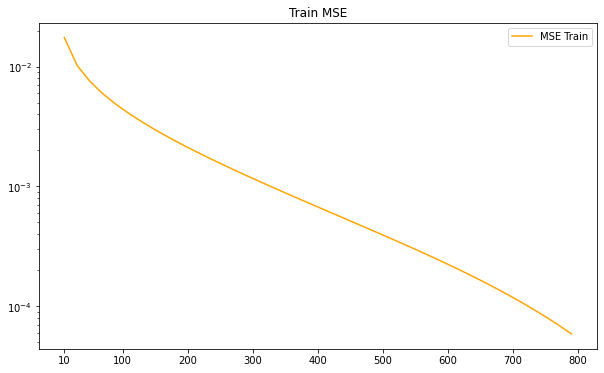

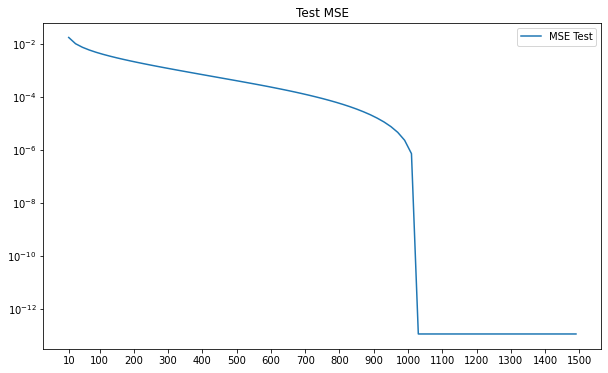

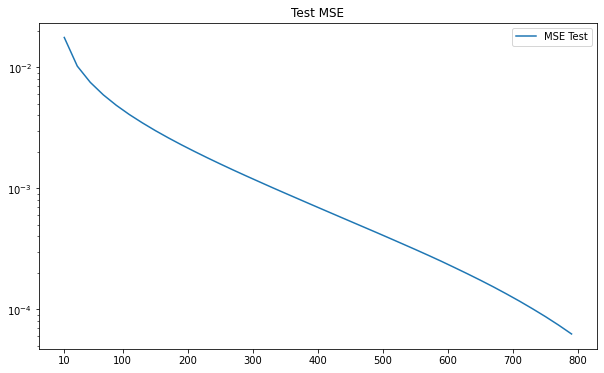

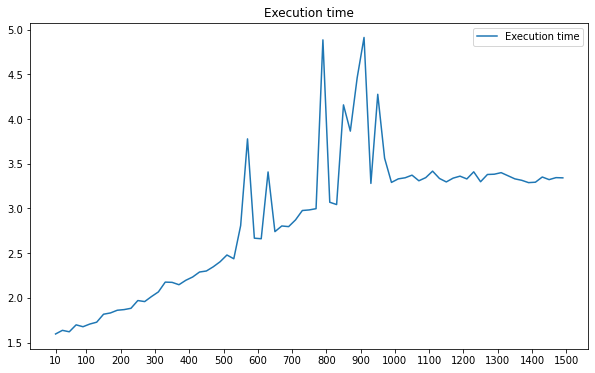

In [ ]:
plot_function(encoding_list , mse_train_list_svd, data = "train")
plot_function(encoding_list , mse_train_list_svd, data = "train", stop = 40) #max stop 75
plot_function(encoding_list , mse_test_list_svd, data = "test")
plot_function(encoding_list , mse_test_list_svd, data = "test", stop = 40)
plot_function(encoding_list, duration_list_svd, data = "time")

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [ ]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 4s 8ms/step - loss: 0.1806 - val_loss: 0.2087
Epoch 2/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0490 - val_loss: 0.0213
Epoch 3/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0249 - val_loss: 0.0168
Epoch 4/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0152 - val_loss: 0.0140
Epoch 5/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 6/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0107
Epoch 7/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 8/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 9/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 10/15
79/79 [==============================] - 1s 6ms/step - loss: 0.0082 - val_loss: 0.0088
Epoch 11/15
79/79 [

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


313/313 - 1s - loss: 0.0054 - 603ms/epoch - 2ms/step
Test mse: 0.00540


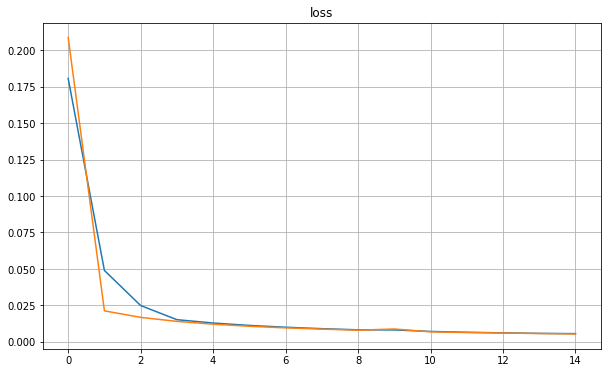

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

313/313 [==============================] - 0s 1ms/step


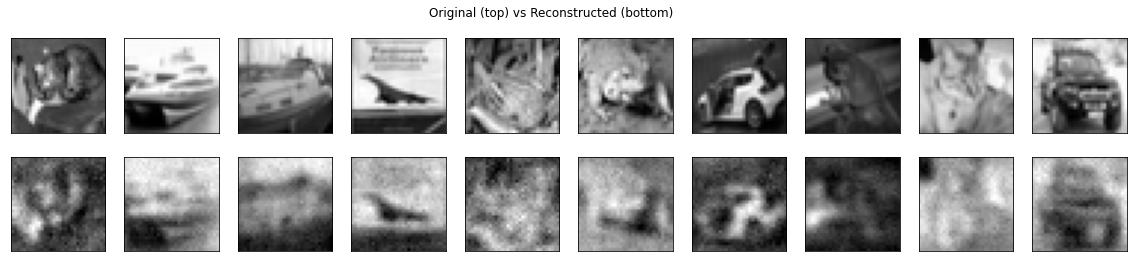

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

### Question

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


_Answer:_ The Shallow Linear Autoencoder (with 15 epochs) is slower than the Single Value Decomposition and the SVD is better with respect to the Mean Squared Error measure, infact we can see in the plots below that the mse in the svd in always reducing until the encoding dimension wont reach the sample dimension: After that the mse is dropping to a theoretical zero. On the other hand the mse of the SLA stays always way bigger than the mse of the SLA and for encoding dimensions higher than the sample dimension it is overfitting. 

### Testing

#### Some plots with different encoding dimension

Iteration with encoding dim: 16
Train mse: 0.014390837401152
Test mse: 0.014480961486697


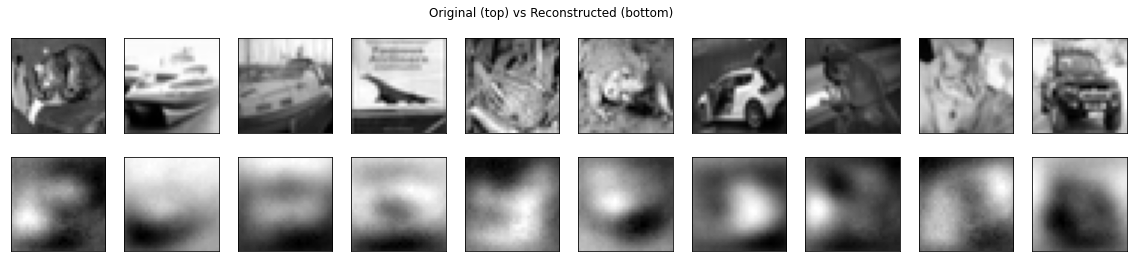

Iteration with encoding dim: 64
Train mse: 0.007516697049141
Test mse: 0.007562596816570


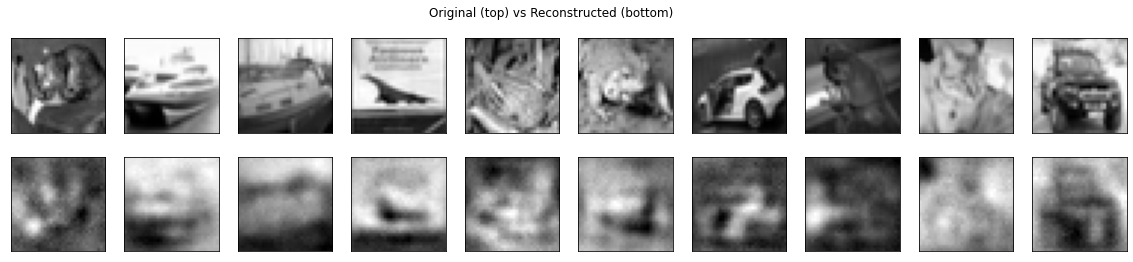

Iteration with encoding dim: 128
Train mse: 0.006170736160129
Test mse: 0.006215611938387


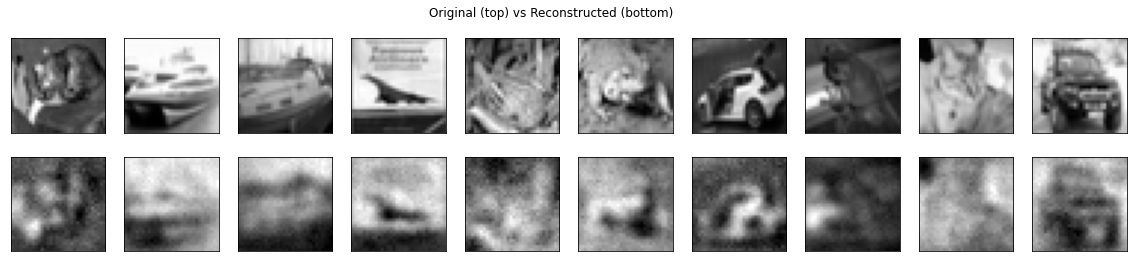

Iteration with encoding dim: 256
Train mse: 0.005405489355326
Test mse: 0.005459482781589


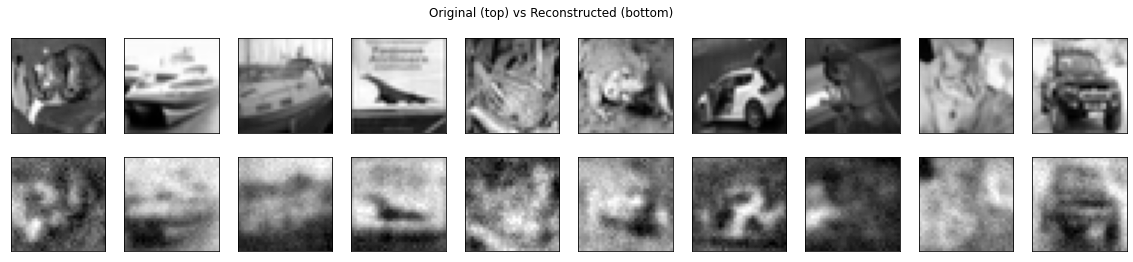

Iteration with encoding dim: 512
Train mse: 0.008069420233369
Test mse: 0.008163281716406


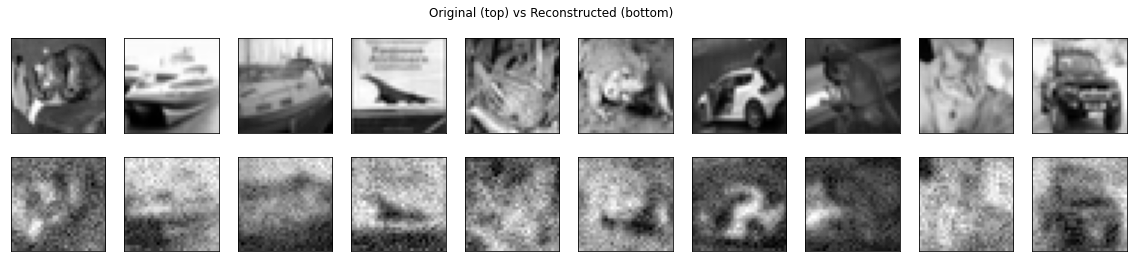

Iteration with encoding dim: 768
Train mse: 0.007251766044647
Test mse: 0.007308314554393


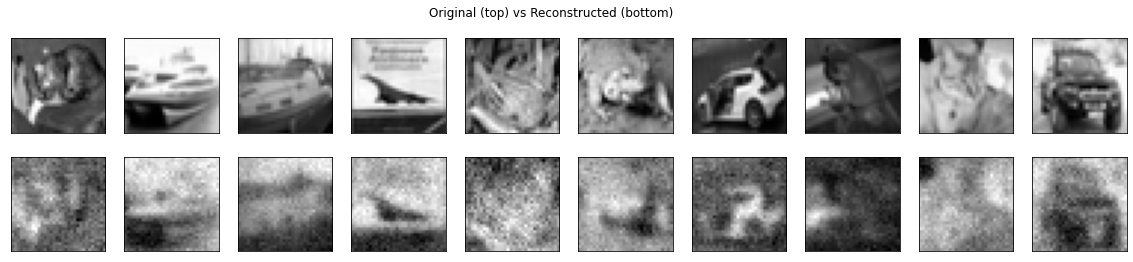

Iteration with encoding dim: 1024
Train mse: 0.007924308069050
Test mse: 0.007992857135832


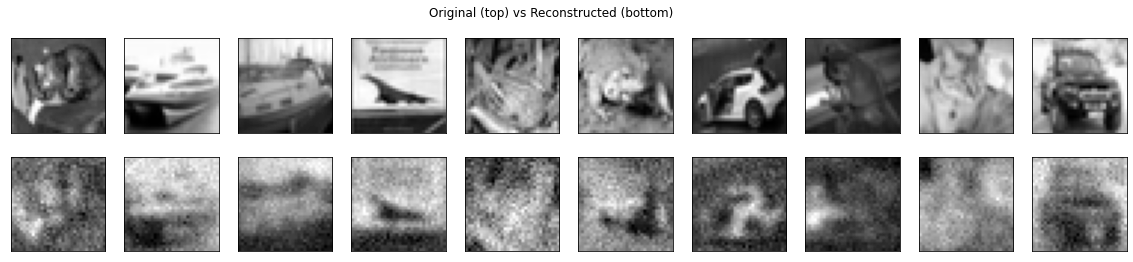

Iteration with encoding dim: 1500
Train mse: 0.009774977341294
Test mse: 0.009847601875663


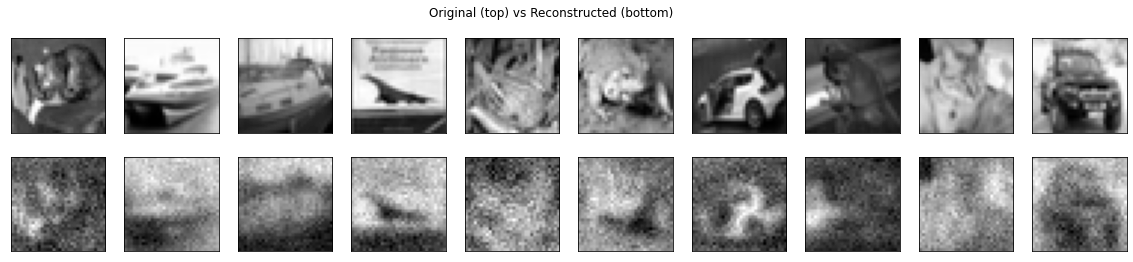

Iteration with encoding dim: 2000
Train mse: 0.011348388157785
Test mse: 0.011422405950725


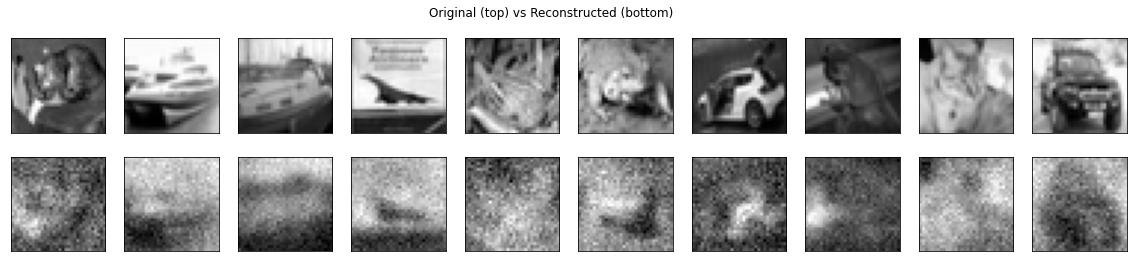

In [ ]:
encoding_list = [16,64,128,256,512,768,1024,1500,2000]

for ENCODING_DIM in encoding_list:
  INPUT_DIM = x_train.shape[-1]
  input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
  encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)
  decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)
  autoencoder = tf.keras.models.Model(input_img, decoded)
  encoder = tf.keras.models.Model(input_img, encoded)
  encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
  decoder_layer = autoencoder.layers[-1]
  decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
  #autoencoder.summary()
  history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid),verbose =0)
  #plot_loss(history)
  scores_test = autoencoder.evaluate(x_test, x_test, verbose=0)
  scores_train = autoencoder.evaluate(x_train, x_train, verbose=0)
  print("Iteration with encoding dim: {}".format(ENCODING_DIM))
  print("Train mse: %.15f" % (scores_train))
  print("Test mse: %.15f" % (scores_test))
  encoded_imgs = encoder.predict(x_test, verbose = 0)
  decoded_imgs = decoder.predict(encoded_imgs, verbose = 0)
  plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

#### Testing for many different encoding dimension

In [ ]:
mse_train_list_SLA = []
mse_test_list_SLA = []
duration_list_SLA = []
encoding_list = list(range(10, 1500, 20))

for ENCODING_DIM in encoding_list:
  start = time.time()
  INPUT_DIM = x_train.shape[-1]
  input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
  encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)
  decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)
  autoencoder = tf.keras.models.Model(input_img, decoded)
  encoder = tf.keras.models.Model(input_img, encoded)
  encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
  decoder_layer = autoencoder.layers[-1]
  decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
  #autoencoder.summary()
  history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid),verbose =0)
  #plot_loss(history)
  scores_test = autoencoder.evaluate(x_test, x_test, verbose=0)
  scores_train = autoencoder.evaluate(x_train, x_train, verbose=0)
  mse_train_list_SLA.append(scores_train)
  mse_test_list_SLA.append(scores_test)
  end = time.time()
  execution_time = end - start
  duration_list_SLA.append(execution_time)
  print("Iteration with encoding dim: {}".format(ENCODING_DIM))
  print("Train mse: %.15f" % (scores_train))
  print("Test mse: %.15f" % (scores_test))
  print("Execution time: %.3f" %(execution_time))
  encoded_imgs = encoder.predict(x_test, verbose = 0)
  decoded_imgs = decoder.predict(encoded_imgs, verbose = 0)
 

Iteration with encoding dim: 10
Train mse: 0.017748577520251
Test mse: 0.017846850678325
Execution time: 13.550
Iteration with encoding dim: 30
Train mse: 0.010592665523291
Test mse: 0.010648570954800
Execution time: 9.201
Iteration with encoding dim: 50
Train mse: 0.008407901972532
Test mse: 0.008452530018985
Execution time: 9.121
Iteration with encoding dim: 70
Train mse: 0.007634869311005
Test mse: 0.007678782101721
Execution time: 8.959
Iteration with encoding dim: 90
Train mse: 0.006869549397379
Test mse: 0.006914801895618
Execution time: 13.699
Iteration with encoding dim: 110
Train mse: 0.006341889034957
Test mse: 0.006381409242749
Execution time: 14.143
Iteration with encoding dim: 130
Train mse: 0.005904323421419
Test mse: 0.005947517231107
Execution time: 9.102
Iteration with encoding dim: 150
Train mse: 0.005719637963921
Test mse: 0.005759980529547
Execution time: 14.138
Iteration with encoding dim: 170
Train mse: 0.005443065892905
Test mse: 0.005481859203428
Execution time:

The following plots pushed me to study more around (180,200) and I am going to do it after. 

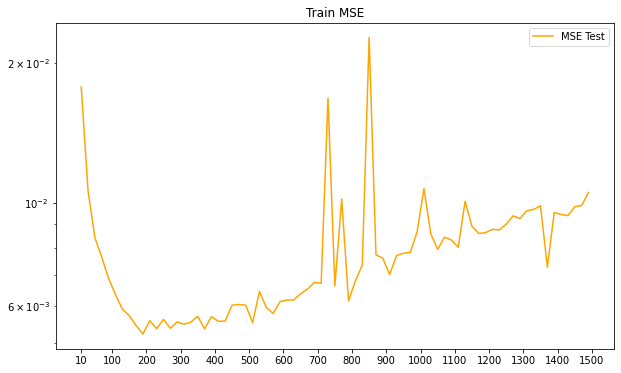

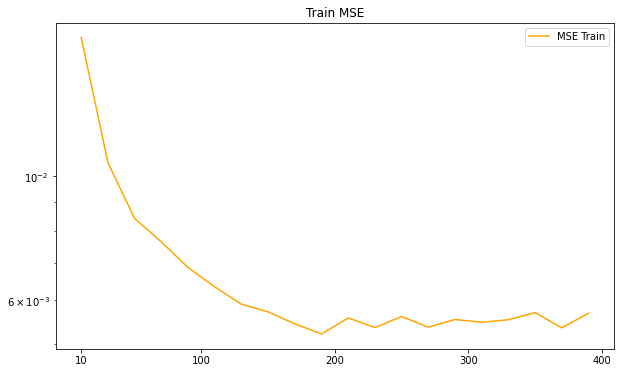

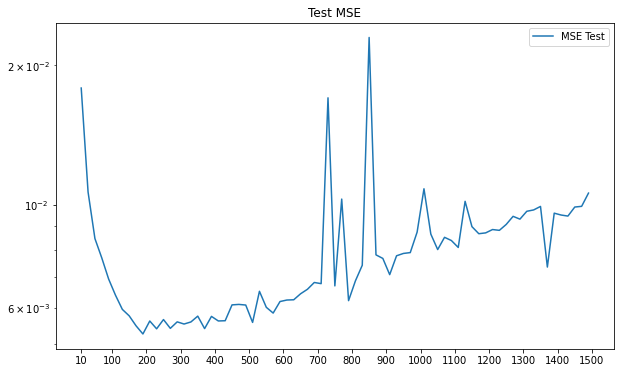

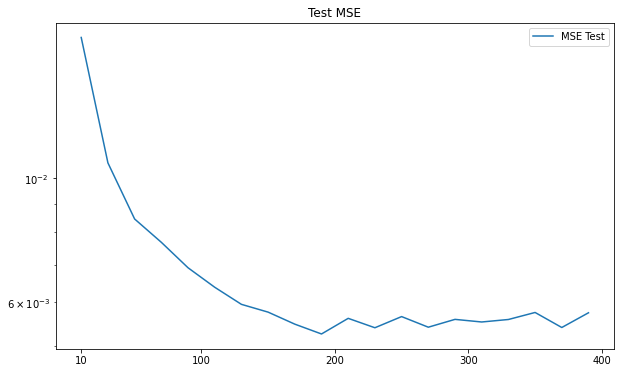

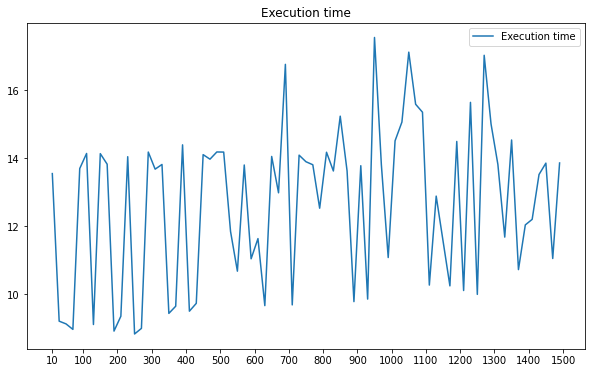

In [ ]:
plot_function(encoding_list , mse_train_list_SLA, data = "train")
plot_function(encoding_list , mse_train_list_SLA, data = "train", stop = 20)
plot_function(encoding_list , mse_test_list_SLA, data = "test")
plot_function(encoding_list , mse_test_list_SLA, data = "test", stop = 20)
plot_function(encoding_list, duration_list_SLA, data = "time")

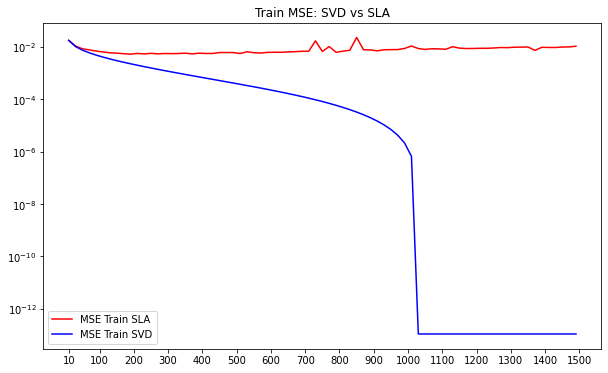

In [ ]:
#now we see the plot of SVD and SLA togheder - Train set
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list, mse_train_list_SLA, label='MSE Train SLA', color = "red")
plt.semilogy(encoding_list, mse_train_list_svd, label='MSE Train SVD', color = "blue")
ticks = range(0,max(encoding_list)+100,100)
plt.title("Train MSE: SVD vs SLA")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

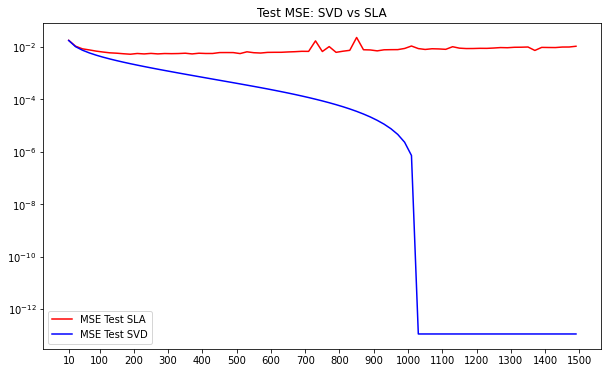

In [ ]:
#now we see the plot of SVD and SLA togheder - Test set
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list, mse_test_list_SLA, label='MSE Test SLA', color = "red")
plt.semilogy(encoding_list, mse_test_list_svd, label='MSE Test SVD', color = "blue")
ticks = range(0,max(encoding_list)+100,100)
plt.title("Test MSE: SVD vs SLA")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

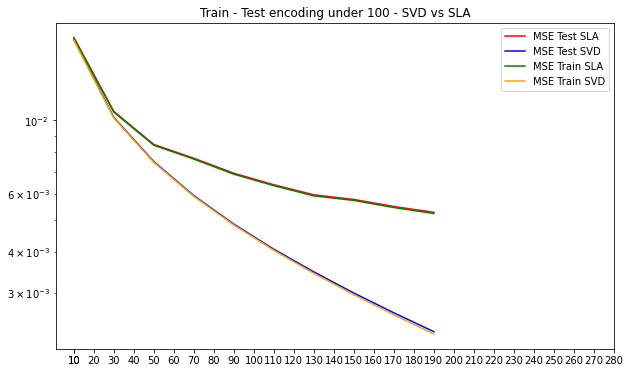

In [ ]:
#now we see the plot of SVD and SLA togheder - Test set and Train set with encoding dim 200
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list[:10], mse_test_list_SLA[:10], label='MSE Test SLA', color = "red")
plt.semilogy(encoding_list[:10], mse_test_list_svd[:10], label='MSE Test SVD', color = "blue")
plt.semilogy(encoding_list[:10], mse_train_list_SLA[:10], label='MSE Train SLA', color = "green")
plt.semilogy(encoding_list[:10], mse_train_list_svd[:10], label='MSE Train SVD', color = "orange")
ticks = range(0,max(encoding_list[:10])+100,10)
plt.title("Train - Test encoding under 100 - SVD vs SLA")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

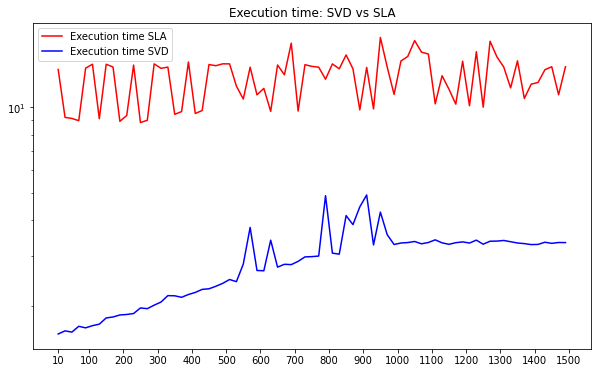

In [ ]:
#now we see the plot of SVD and SLA togheder - Execution time
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list, duration_list_SLA, label='Execution time SLA',  color = "red")
plt.semilogy(encoding_list, duration_list_svd, label='Execution time SVD',  color = "blue")
ticks = range(0,max(encoding_list)+100,100)
plt.title("Execution time: SVD vs SLA")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

#### SVD vs SLA: deeper into encoding dimension between 0 and 50

In [ ]:
mse_train_list_SLA_t = []
mse_test_list_SLA_t = []
encoding_list_t = list(range(1, 50, 1))

for ENCODING_DIM in encoding_list_t:
  INPUT_DIM = x_train.shape[-1]
  input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
  encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)
  decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)
  autoencoder = tf.keras.models.Model(input_img, decoded)
  encoder = tf.keras.models.Model(input_img, encoded)
  encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
  decoder_layer = autoencoder.layers[-1]
  decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
  #autoencoder.summary()
  history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid),verbose =0)
  #plot_loss(history)
  scores_test = autoencoder.evaluate(x_test, x_test, verbose=0)
  scores_train = autoencoder.evaluate(x_train, x_train, verbose=0)
  mse_train_list_SLA_t.append(scores_train)
  mse_test_list_SLA_t.append(scores_test)
  print("Iteration with encoding dim: {}".format(ENCODING_DIM))
  print("Train mse: %.15f" % (scores_train))
  print("Test mse: %.15f" % (scores_test))
  encoded_imgs = encoder.predict(x_test, verbose = 0)
  decoded_imgs = decoder.predict(encoded_imgs, verbose = 0)

mse_test_list_svd_t = []
mse_train_list_svd_t = []

for ENCODING_DIM in encoding_list_t:
  U_k = SVD(x_train, ENCODING_DIM)
  x_training_svd = np.dot(x_train, U_k)
  x_test_svd = np.dot(x_test, U_k)
  x_training_reco = np.dot(x_training_svd, U_k.T)
  x_test_reco = np.dot(x_test_svd, U_k.T)
  accuracy_train = ((x_train - x_training_reco)**2).mean()
  accuracy_test = ((x_test - x_test_reco)**2).mean()
  mse_train_list_svd_t.append(accuracy_train)
  mse_test_list_svd_t.append(accuracy_test)
  print("Iteration with encoding dim: {}".format(ENCODING_DIM))
  print("Train mse: %.15f" % ( accuracy_train))
  print("Test mse: %.15f" % (accuracy_test ))
 

Iteration with encoding dim: 1
Train mse: 0.038694232702255
Test mse: 0.038541212677956
Iteration with encoding dim: 2
Train mse: 0.031699955463409
Test mse: 0.031771659851074
Iteration with encoding dim: 3
Train mse: 0.027604626491666
Test mse: 0.027601409703493
Iteration with encoding dim: 4
Train mse: 0.025667339563370
Test mse: 0.025723200291395
Iteration with encoding dim: 5
Train mse: 0.023645676672459
Test mse: 0.023692803457379
Iteration with encoding dim: 6
Train mse: 0.021946756169200
Test mse: 0.022027211263776
Iteration with encoding dim: 7
Train mse: 0.020636014640331
Test mse: 0.020758017897606
Iteration with encoding dim: 8
Train mse: 0.019416736438870
Test mse: 0.019539823755622
Iteration with encoding dim: 9
Train mse: 0.018473396077752
Test mse: 0.018566098064184
Iteration with encoding dim: 10
Train mse: 0.017648642882705
Test mse: 0.017767343670130
Iteration with encoding dim: 11
Train mse: 0.017051501199603
Test mse: 0.017140280455351
Iteration with encoding dim: 1

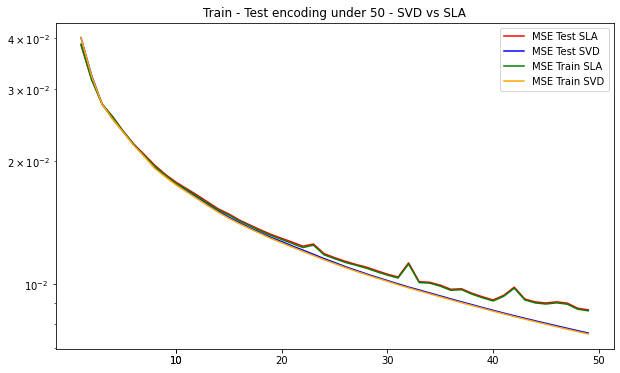

In [ ]:
#now we see the plot of SVD and SLA togheder - Test set and Train set with encoding dim under 50
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list_t, mse_test_list_SLA_t, label='MSE Test SLA', color = "red")
plt.semilogy(encoding_list_t, mse_test_list_svd_t, label='MSE Test SVD', color = "blue")
plt.semilogy(encoding_list_t, mse_train_list_SLA_t, label='MSE Train SLA', color = "green")
plt.semilogy(encoding_list_t, mse_train_list_svd_t, label='MSE Train SVD', color = "orange")
ticks = range(0,max(encoding_list_t)+10,10)
plt.title("Train - Test encoding under 50 - SVD vs SLA")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

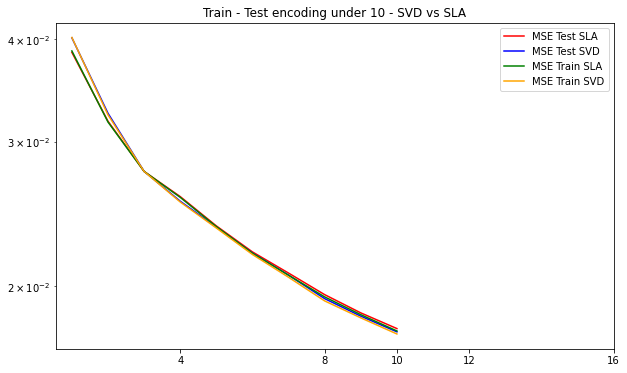

In [ ]:
#now we see the plot of SVD and SLA togheder - Test set and Train set with encoding dim under 10
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list_t[:10], mse_test_list_SLA_t[:10], label='MSE Test SLA', color = "red")
plt.semilogy(encoding_list_t[:10], mse_test_list_svd_t[:10], label='MSE Test SVD', color = "blue")
plt.semilogy(encoding_list_t[:10], mse_train_list_SLA_t[:10], label='MSE Train SLA', color = "green")
plt.semilogy(encoding_list_t[:10], mse_train_list_svd_t[:10], label='MSE Train SVD', color = "orange")
ticks = range(0,max(encoding_list_t[:10])+10,4)
plt.title("Train - Test encoding under 10 - SVD vs SLA")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

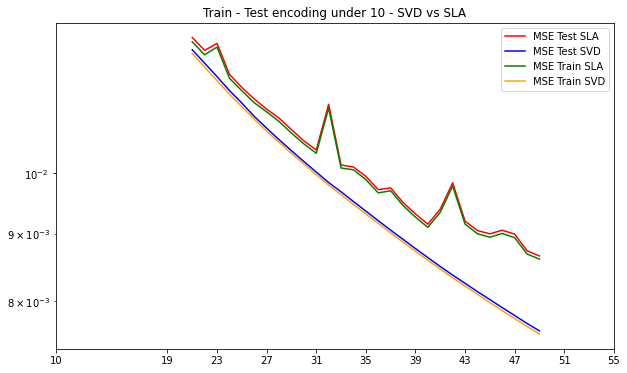

In [ ]:
#now we see the plot of SVD and SLA togheder - Test set and Train set with encoding dim in [20,50]
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list_t[20:], mse_test_list_SLA_t[20:], label='MSE Test SLA', color = "red")
plt.semilogy(encoding_list_t[20:], mse_test_list_svd_t[20:], label='MSE Test SVD', color = "blue")
plt.semilogy(encoding_list_t[20:], mse_train_list_SLA_t[20:], label='MSE Train SLA', color = "green")
plt.semilogy(encoding_list_t[20:], mse_train_list_svd_t[20:], label='MSE Train SVD', color = "orange")
ticks = range(15,max(encoding_list_t[20:])+10,4)
plt.title("Train - Test encoding under 10 - SVD vs SLA")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

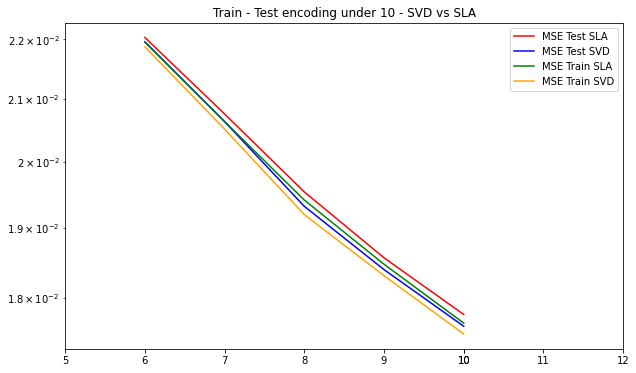

In [ ]:
#now we see the plot of SVD and SLA togheder - Test set and Train set with encoding dim in [5,10]
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list_t[5:10], mse_test_list_SLA_t[5:10], label='MSE Test SLA', color = "red")
plt.semilogy(encoding_list_t[5:10], mse_test_list_svd_t[5:10], label='MSE Test SVD', color = "blue")
plt.semilogy(encoding_list_t[5:10], mse_train_list_SLA_t[5:10], label='MSE Train SLA', color = "green")
plt.semilogy(encoding_list_t[5:10], mse_train_list_svd_t[5:10], label='MSE Train SVD', color = "orange")
ticks = range(4,max(encoding_list_t[5:10])+3,1)
plt.title("Train - Test encoding under 10 - SVD vs SLA")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

#### What if the epoch of SLA is not 15?

In [ ]:
mse_train_list_SLA_30epo = []
mse_test_list_SLA_30epo = []
duration_list_SLA_30epo = []
mse_train_list_SLA_50epo = []
mse_test_list_SLA_50epo = []
duration_list_SLA_50epo = []
mse_train_list_SLA_80epo = []
mse_test_list_SLA_80epo = []
duration_list_SLA_80epo = []
mse_train_list_SLA_100epo = []
mse_test_list_SLA_100epo = []
duration_list_SLA_100epo = []
encoding_list = list(range(10, 1500, 20))
epoch_list = [30,50,80,100]

for epo in epoch_list:
  for ENCODING_DIM in encoding_list:
    start = time.time()
    INPUT_DIM = x_train.shape[-1]
    input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
    encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)
    decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)
    autoencoder = tf.keras.models.Model(input_img, decoded)
    encoder = tf.keras.models.Model(input_img, encoded)
    encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
    decoder_layer = autoencoder.layers[-1]
    decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
    #autoencoder.summary()
    history = autoencoder.fit(x_train, x_train, epochs=epo, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid),verbose =0)
    #plot_loss(history)
    scores_test = autoencoder.evaluate(x_test, x_test, verbose=0)
    scores_train = autoencoder.evaluate(x_train, x_train, verbose=0)
    end = time.time()
    execution_time = end - start
    if epo == 30: 
        mse_train_list_SLA_30epo.append(scores_train)
        mse_test_list_SLA_30epo.append(scores_test)
        duration_list_SLA_30epo.append(execution_time)

    if epo == 50: 
        mse_train_list_SLA_50epo.append(scores_train)
        mse_test_list_SLA_50epo.append(scores_test)
        duration_list_SLA_50epo.append(execution_time)
    
    if epo == 80: 
        mse_train_list_SLA_80epo.append(scores_train)
        mse_test_list_SLA_80epo.append(scores_test)
        duration_list_SLA_80epo.append(execution_time)

    if epo == 100: 
        mse_train_list_SLA_100epo.append(scores_train)
        mse_test_list_SLA_100epo.append(scores_test)
        duration_list_SLA_100epo.append(execution_time)

    print("Iteration with encoding dim: {} and epoch: {}".format(ENCODING_DIM,epo))
    print("Train mse: %.15f" % (scores_train))
    print("Test mse: %.15f" % (scores_test))
    print("Execution time: %.3f" %(execution_time))
    encoded_imgs = encoder.predict(x_test, verbose = 0)
    decoded_imgs = decoder.predict(encoded_imgs, verbose = 0)
    print("--------------------------------------------------")

Iteration with encoding dim: 10 and epoch: 30
Train mse: 0.017776850610971
Test mse: 0.017891429364681
Execution time: 14.405
--------------------------------------------------
Iteration with encoding dim: 30 and epoch: 30
Train mse: 0.010346124880016
Test mse: 0.010397224687040
Execution time: 14.370
--------------------------------------------------
Iteration with encoding dim: 50 and epoch: 30
Train mse: 0.007856485433877
Test mse: 0.007895947434008
Execution time: 14.573
--------------------------------------------------
Iteration with encoding dim: 70 and epoch: 30
Train mse: 0.007530829403549
Test mse: 0.007571870461106
Execution time: 14.040
--------------------------------------------------
Iteration with encoding dim: 90 and epoch: 30
Train mse: 0.005249361973256
Test mse: 0.005286077503115
Execution time: 24.415
--------------------------------------------------
Iteration with encoding dim: 110 and epoch: 30
Train mse: 0.007273859344423
Test mse: 0.007309948094189
Execution t

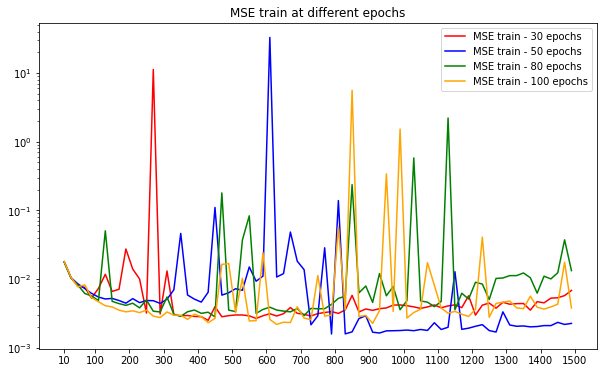

In [ ]:
#now we see the plot of SLA with different epochs - Train set
encoding_list = list(range(10, 1500, 20))
epoch_list = [30,50,80,100]
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list, mse_train_list_SLA_30epo, label='MSE train - 30 epochs',  color = "red")
plt.semilogy(encoding_list, mse_train_list_SLA_50epo, label='MSE train - 50 epochs',  color = "blue")
plt.semilogy(encoding_list, mse_train_list_SLA_80epo, label='MSE train - 80 epochs',  color = "green")
plt.semilogy(encoding_list, mse_train_list_SLA_100epo, label='MSE train - 100 epochs',  color = "orange")
ticks = range(0,max(encoding_list)+100,100)
plt.title("MSE train at different epochs")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

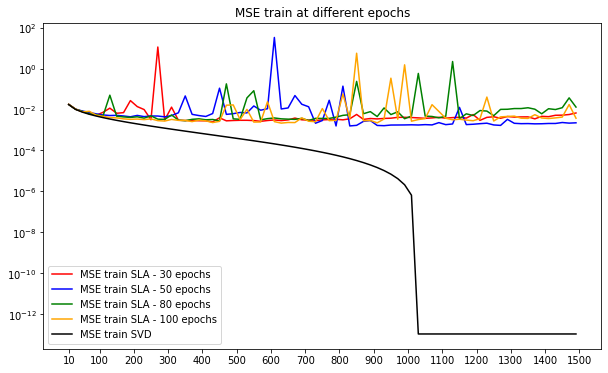

In [ ]:
#now we see the plot of SLA with different epochs - Train set
encoding_list = list(range(10, 1500, 20))
epoch_list = [30,50,80,100]
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list, mse_train_list_SLA_30epo, label='MSE train SLA - 30 epochs',  color = "red")
plt.semilogy(encoding_list, mse_train_list_SLA_50epo, label='MSE train SLA - 50 epochs',  color = "blue")
plt.semilogy(encoding_list, mse_train_list_SLA_80epo, label='MSE train SLA - 80 epochs',  color = "green")
plt.semilogy(encoding_list, mse_train_list_SLA_100epo, label='MSE train SLA - 100 epochs',  color = "orange")
plt.semilogy(encoding_list, mse_train_list_svd, label='MSE train SVD',  color = "black")
ticks = range(0,max(encoding_list)+100,100)
plt.title("MSE train at different epochs")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

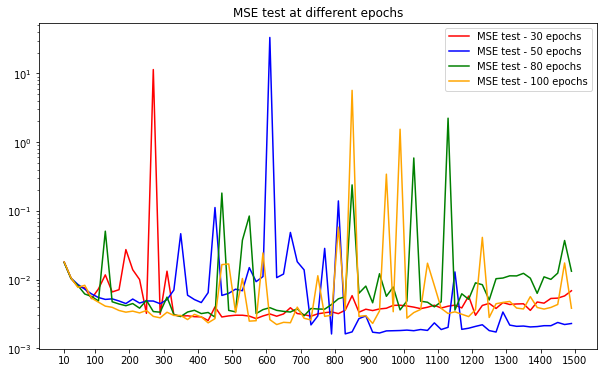

In [ ]:
#now we see the plot of SLA with different epochs - Test set
encoding_list = list(range(10, 1500, 20))
epoch_list = [30,50,80,100]
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list, mse_test_list_SLA_30epo, label='MSE test - 30 epochs',  color = "red")
plt.semilogy(encoding_list, mse_test_list_SLA_50epo, label='MSE test - 50 epochs',  color = "blue")
plt.semilogy(encoding_list, mse_test_list_SLA_80epo, label='MSE test - 80 epochs',  color = "green")
plt.semilogy(encoding_list, mse_test_list_SLA_100epo, label='MSE test - 100 epochs',  color = "orange")
ticks = range(0,max(encoding_list)+100,100)
plt.title("MSE test at different epochs")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

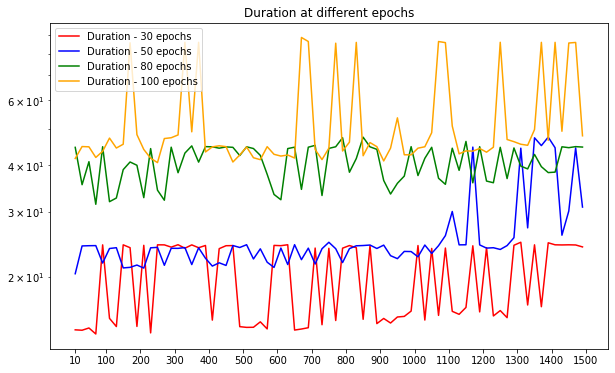

In [ ]:
#now we see the plot of SLA with different epochs - Duration
encoding_list = list(range(10, 1500, 20))
epoch_list = [30,50,80,100]
plt.figure(figsize=(10,6))
plt.semilogy(encoding_list, duration_list_SLA_30epo, label='Duration - 30 epochs',  color = "red")
plt.semilogy(encoding_list, duration_list_SLA_50epo, label='Duration - 50 epochs',  color = "blue")
plt.semilogy(encoding_list, duration_list_SLA_80epo, label='Duration - 80 epochs',  color = "green")
plt.semilogy(encoding_list, duration_list_SLA_100epo, label='Duration - 100 epochs',  color = "orange")
ticks = range(0,max(encoding_list)+100,100)
plt.title("Duration at different epochs")
ticks = list(ticks)
ticks[0] = 10
plt.xticks(ticks)
plt.legend()

#### Tuning enconding dimension around (180, 210) and epochs [15,30,50,80,100]

I want to do some tuning on the hyperparameters so i need a validation set, I decided to create another one so that the first is used in the fitting of the autoencoder and another is used for the hyperparameter tuning. 

In [ ]:
# We extract the first 20000 samples of the training set, to use them as the validation set
x_valid_1 , x_valid_2, x_train_1 = X_train_full[:10000],X_train_full[10000:20000], X_train_full[20000:]

In [ ]:
encoding_list_tuning = list(range(180, 210, 1))
epoch_list_tuning = [15,30,50,80,100] #MODIFY THIS BEFORE RUNNING
result_tuning = dict()

for epo in epoch_list_tuning:
  for ENCODING_DIM in encoding_list_tuning:
    start = time.time()
    INPUT_DIM = x_train_1.shape[-1]
    input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
    encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)
    decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)
    autoencoder = tf.keras.models.Model(input_img, decoded)
    encoder = tf.keras.models.Model(input_img, encoded)
    encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
    decoder_layer = autoencoder.layers[-1]
    decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
    history = autoencoder.fit(x_train_1, x_train_1, epochs=epo, batch_size=512, shuffle=True, validation_data=(x_valid_1, x_valid_1),verbose =0)
    scores_valid = autoencoder.evaluate(x_valid_2, x_valid_2, verbose=0)
    scores_train = autoencoder.evaluate(x_train_1, x_train_1, verbose=0)
    end = time.time()
    execution_time = end - start
    result_tuning[(ENCODING_DIM,epo)] = (scores_train,scores_valid)

    print("Iteration with encoding dim: {} and epoch: {}".format(ENCODING_DIM,epo))
    print("Train mse: %.15f" % (scores_train))
    print("Valid mse: %.15f" % (scores_valid))
    print("Execution time: %.3f" %(execution_time))
    encoded_imgs = encoder.predict(x_test, verbose = 0)
    decoded_imgs = decoder.predict(encoded_imgs, verbose = 0)
    print("--------------------------------------------------")

Iteration with encoding dim: 180 and epoch: 15
Train mse: 0.006703095510602
Valid mse: 0.006809304002672
Execution time: 9.222
--------------------------------------------------
Iteration with encoding dim: 181 and epoch: 15
Train mse: 0.007109516300261
Valid mse: 0.007215439807624
Execution time: 6.781
--------------------------------------------------
Iteration with encoding dim: 182 and epoch: 15
Train mse: 0.006804390810430
Valid mse: 0.006911086849868
Execution time: 6.682
--------------------------------------------------
Iteration with encoding dim: 183 and epoch: 15
Train mse: 0.008502293378115
Valid mse: 0.008615699596703
Execution time: 7.924
--------------------------------------------------
Iteration with encoding dim: 184 and epoch: 15
Train mse: 0.006576979532838
Valid mse: 0.006677225697786
Execution time: 6.627
--------------------------------------------------
Iteration with encoding dim: 185 and epoch: 15
Train mse: 0.006834387779236
Valid mse: 0.006939309649169
Execu

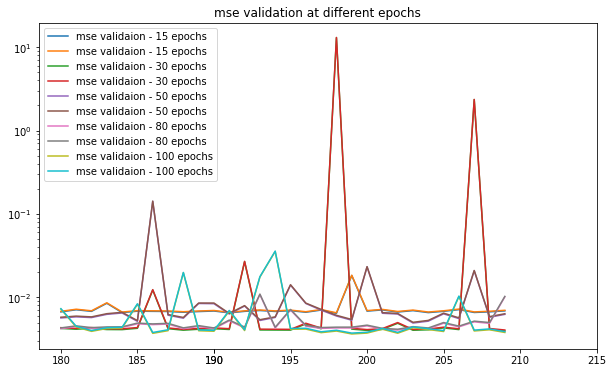

In [ ]:
#now we see the plot of SLA with different epochs - mse validation

plt.figure(figsize=(10,6))
for epo in epoch_list_tuning:
  plt.semilogy(encoding_list_tuning, [result_tuning[(i,epo)] for i in encoding_list_tuning ], label='mse validaion - {} epochs'.format(epo))
ticks = range(175,max(encoding_list_tuning )+10,5)
plt.title("mse validation at different epochs")
ticks = list(ticks)
ticks[0] = 190
plt.xticks(ticks)
plt.legend()


In [ ]:
best_epo = 0
best_enc_dim = 0
best_mse = 10

for epo in epoch_list_tuning:
  for ENCODING_DIM in encoding_list_tuning:
    r = result_tuning[(ENCODING_DIM,epo)][0]
    if r<best_mse:
      best_mse = r
      best_epo = epo
      best_enc_dim = ENCODING_DIM

print("best encoding dim: {}, best epochs: {}, mse validation: {}".format(best_enc_dim,best_epo,best_mse))

best encoding dim: 199, best epochs: 100, mse validation: 0.0036449322942644358


##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


#### Question

risposta qui

#### Testing encoding dim 256 with different activation functions and 15 epochs

Model: "model_768"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_513 (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_512 (Dense)           (None, 256)               262400    
                                                                 
 dense_513 (Dense)           (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
79/79 [==============================] - 1s 7ms/step - loss: 0.0338 - val_loss: 0.0206
Epoch 2/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0195 - val_loss: 0.0173
Epoch 3/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0157 - val_loss: 0.0145
Epoch 4/15
79/79 [===

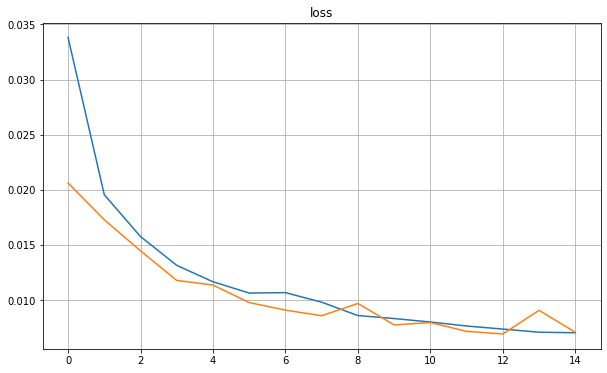

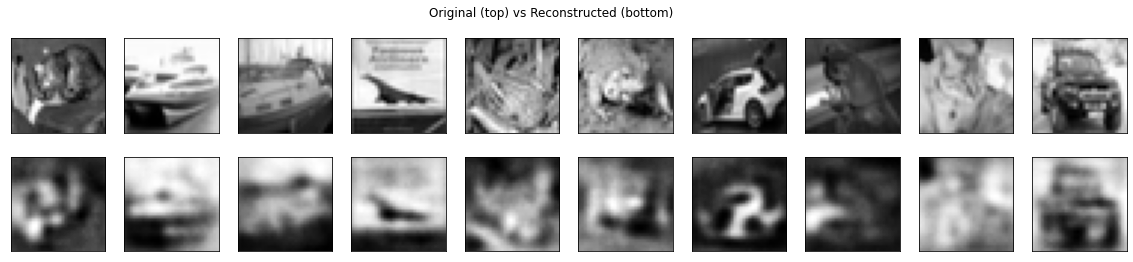

In [ ]:
#Original version with econding dim 256 and sigmoid activation function 
ENCODING_DIM = 256 
INPUT_DIM = x_train.shape[-1]
input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
autoencoder.summary()
history_sigm_1 = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
plot_loss(history_sigm_1)
scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

Model: "model_771"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_515 (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_514 (Dense)           (None, 256)               262400    
                                                                 
 dense_515 (Dense)           (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
79/79 [==============================] - 1s 8ms/step - loss: 0.0941 - val_loss: 0.0407
Epoch 2/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0387 - val_loss: 0.0345
Epoch 3/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0357 - val_loss: 0.0356
Epoch 4/15
79/79 [===

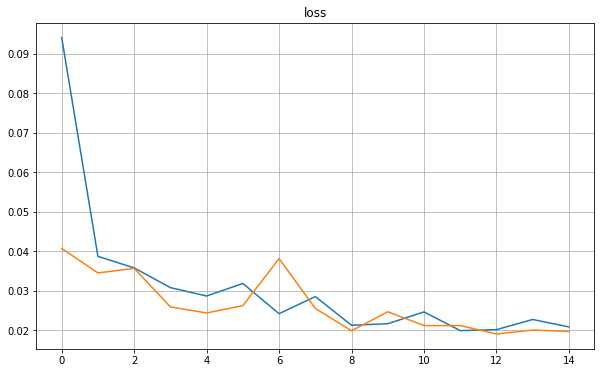

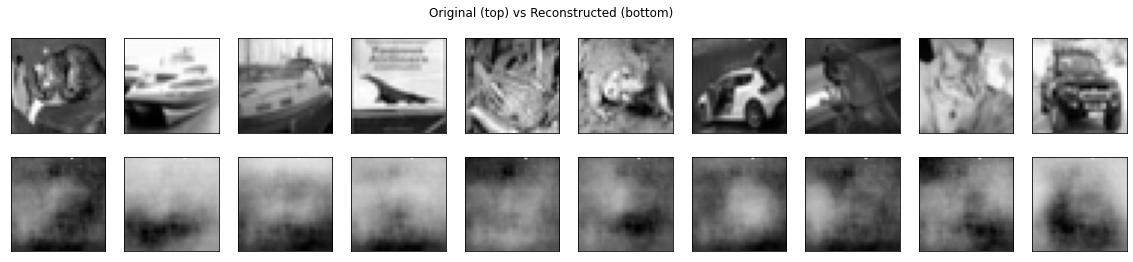

In [ ]:
#Original version with econding dim 256 and tanh activation function 
ENCODING_DIM = 256 
INPUT_DIM = x_train.shape[-1]
input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='tanh')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='tanh')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
autoencoder.summary()
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
plot_loss(history)
scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

Model: "model_774"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_517 (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_516 (Dense)           (None, 256)               262400    
                                                                 
 dense_517 (Dense)           (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
79/79 [==============================] - 1s 7ms/step - loss: 0.1229 - val_loss: 0.0632
Epoch 2/15
79/79 [==============================] - 0s 5ms/step - loss: 0.0548 - val_loss: 0.0492
Epoch 3/15
79/79 [==============================] - 0s 6ms/step - loss: 0.0468 - val_loss: 0.0450
Epoch 4/15
79/79 [===

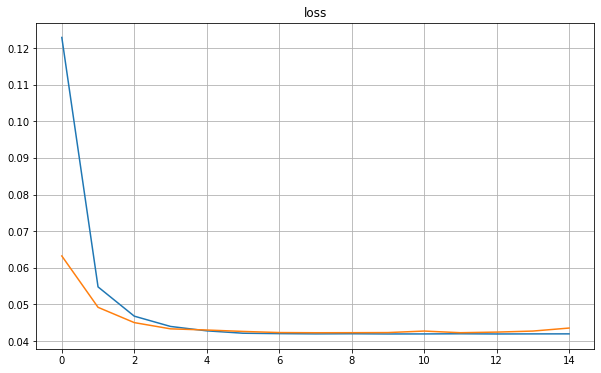

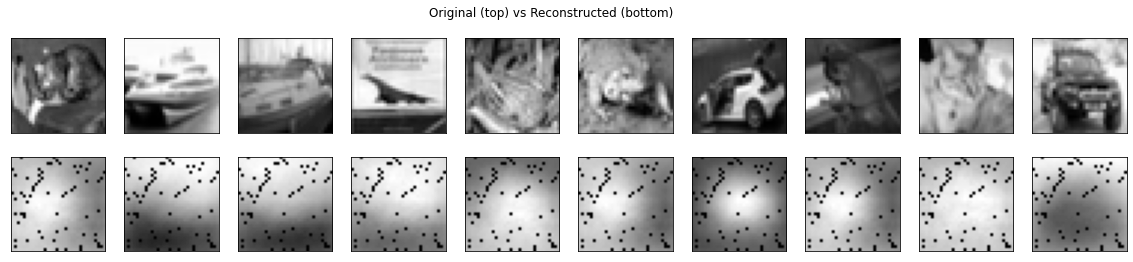

In [ ]:
#Original version with econding dim 256 and ReLu activation function 
ENCODING_DIM = 256 
INPUT_DIM = x_train.shape[-1]
input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='relu')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
autoencoder.summary()
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
plot_loss(history)
scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

#### Testing encoding dim 199 with different activation functions and 100 epochs

Model: "model_777"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_519 (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_518 (Dense)           (None, 199)               203975    
                                                                 
 dense_519 (Dense)           (None, 1024)              204800    
                                                                 
Total params: 408,775
Trainable params: 408,775
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0352 - val_loss: 0.0251
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0191 - val_loss: 0.0182
Epoch 3/100
79/79 [==============================] - 1s 9ms/step - loss: 0.0152 - val_loss: 0.0139
Epoch 4/100
79/79 

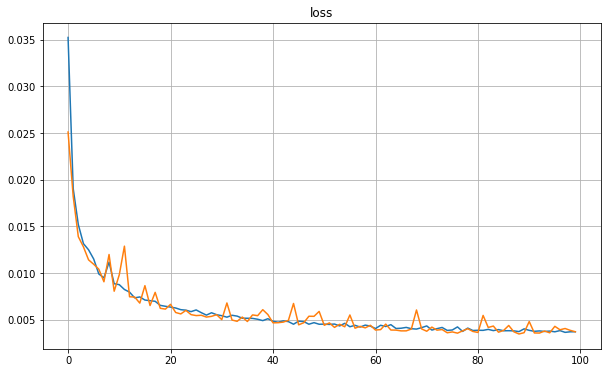

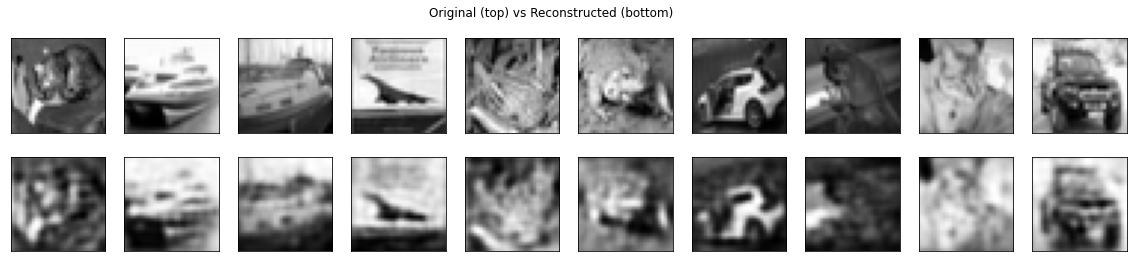

In [ ]:
# Version with econding dim 199 and sigmoid activation function 100 epochs
ENCODING_DIM = 199
INPUT_DIM = x_train.shape[-1]
input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
autoencoder.summary()
history_sigm_2 = autoencoder.fit(x_train, x_train, epochs=100, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
plot_loss(history_sigm_2)
scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

Model: "model_780"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_521 (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_520 (Dense)           (None, 199)               203975    
                                                                 
 dense_521 (Dense)           (None, 1024)              204800    
                                                                 
Total params: 408,775
Trainable params: 408,775
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 1s 10ms/step - loss: 0.0827 - val_loss: 0.0392
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0394 - val_loss: 0.0340
Epoch 3/100
79/79 [==============================] - 1s 7ms/step - loss: 0.0350 - val_loss: 0.0373
Epoch 4/100
79/79

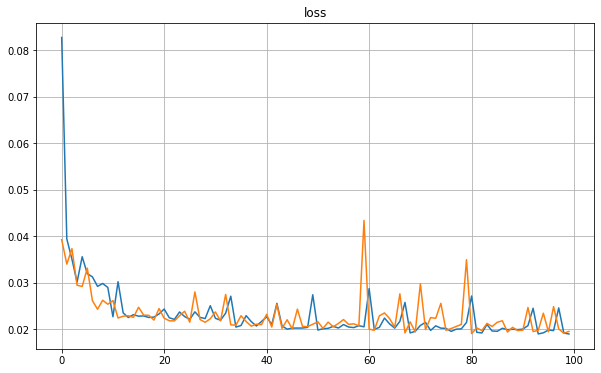

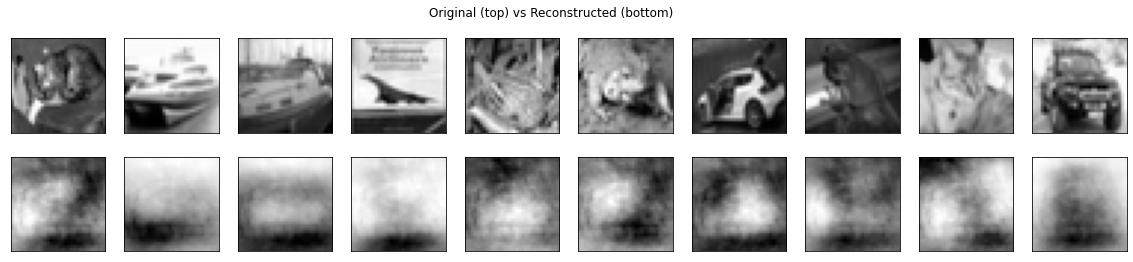

In [ ]:
# Version with econding dim 199 and tanh activation function 100 epochs
ENCODING_DIM = 199
INPUT_DIM = x_train.shape[-1]
input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='tanh')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='tanh')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
autoencoder.summary()
history = autoencoder.fit(x_train, x_train, epochs=100, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
plot_loss(history)
scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

Model: "model_783"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_523 (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_522 (Dense)           (None, 199)               203975    
                                                                 
 dense_523 (Dense)           (None, 1024)              204800    
                                                                 
Total params: 408,775
Trainable params: 408,775
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
79/79 [==============================] - 1s 11ms/step - loss: 0.1256 - val_loss: 0.0739
Epoch 2/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0605 - val_loss: 0.0521
Epoch 3/100
79/79 [==============================] - 0s 5ms/step - loss: 0.0478 - val_loss: 0.0469
Epoch 4/100
79/79

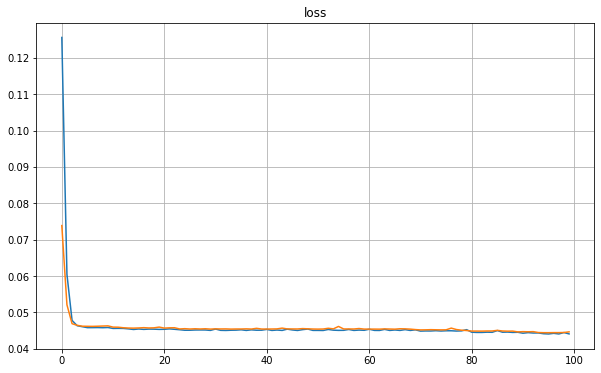

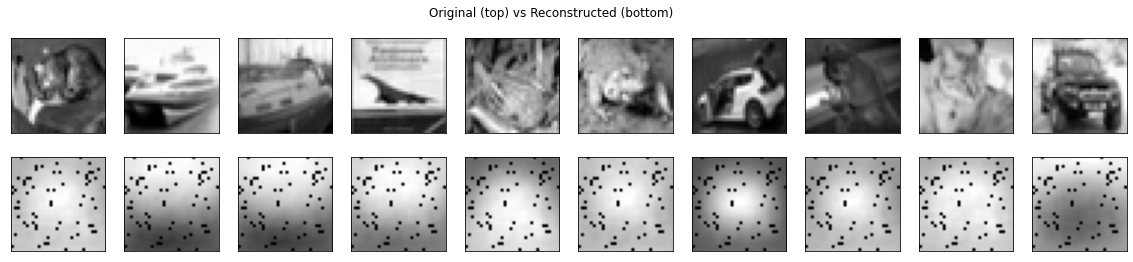

In [ ]:
# Version with econding dim 199 and relu activation function 100 epochs
ENCODING_DIM = 199
INPUT_DIM = x_train.shape[-1]
input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='relu')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')
autoencoder.summary()
history = autoencoder.fit(x_train, x_train, epochs = 100, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))
plot_loss(history)
scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

### Comparing the results with the sigmoig activation

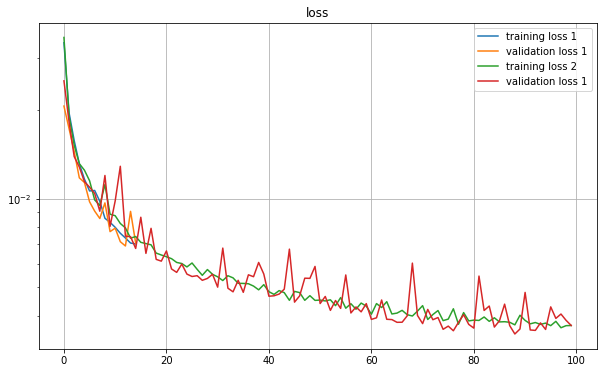

In [ ]:
plot_loss(history_sigm_1,history_2 = history_sigm_2, comparison = True)


We can see that they are comparable wrt the encoding dimension, but with more epochs it is really better.

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


#### Deep Autoencoder 1

In [ ]:
input_dim = x_train.shape[-1]
input = tf.keras.layers.Input(shape=(input_dim,))
encoder_1 = tf.keras.layers.Dense(128, activation='sigmoid')(input)
encoded = tf.keras.layers.Dense(64, activation='linear')(encoder_1)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input, decoded) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')


In [ ]:
autoencoder.summary()

Model: "model_800"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_539 (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_617 (Dense)           (None, 128)               131200    
                                                                 
 dense_618 (Dense)           (None, 64)                8256      
                                                                 
 dense_619 (Dense)           (None, 1024)              66560     
                                                                 
Total params: 206,016
Trainable params: 206,016
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 128, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
313/313 [==============================] - 2s 4ms/step - loss: 0.0239 - val_loss: 0.0175
Epoch 2/15
313/313 [==============================] - 2s 5ms/step - loss: 0.0145 - val_loss: 0.0126
Epoch 3/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0149 - val_loss: 0.0123
Epoch 4/15
313/313 [==============================] - 1s 4ms/step - loss: 0.0131 - val_loss: 0.0111
Epoch 5/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 6/15
313/313 [==============================] - 1s 4ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 7/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 8/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0098 - val_loss: 0.0118
Epoch 9/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 10/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0088

313/313 - 1s - loss: 0.0085 - 501ms/epoch - 2ms/step
test mse: 0.00845


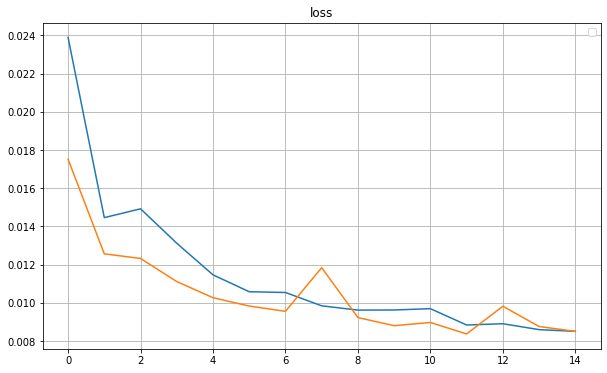

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

313/313 [==============================] - 1s 2ms/step


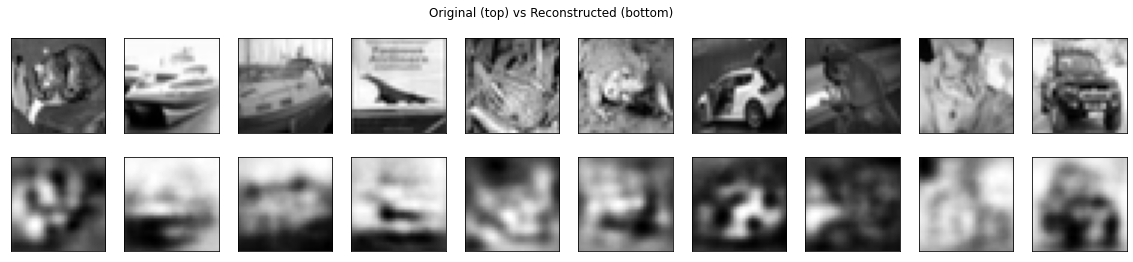

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

### Deep Autoencoder 2

In [ ]:
input_dim = x_train.shape[-1]
input = tf.keras.layers.Input(shape=(input_dim,))
encoder_1 = tf.keras.layers.Dense(256, activation='sigmoid')(input)
encoder_2 = tf.keras.layers.Dense(128, activation='sigmoid')(encoder_1)
encoded = tf.keras.layers.Dense(64, activation='linear')(encoder_2)
decoder_1 = tf.keras.layers.Dense(128, activation='sigmoid')(encoded)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder_1)
autoencoder = tf.keras.models.Model(input, decoded) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')


In [ ]:
autoencoder.summary()

Model: "model_796"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_535 (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_589 (Dense)           (None, 256)               262400    
                                                                 
 dense_590 (Dense)           (None, 128)               32896     
                                                                 
 dense_591 (Dense)           (None, 64)                8256      
                                                                 
 dense_592 (Dense)           (None, 128)               8320      
                                                                 
 dense_593 (Dense)           (None, 1024)              132096    
                                                                 
Total params: 443,968
Trainable params: 443,968
Non-train

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 128, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
313/313 [==============================] - 2s 5ms/step - loss: 0.0344 - val_loss: 0.0280
Epoch 2/15
313/313 [==============================] - 1s 4ms/step - loss: 0.0268 - val_loss: 0.0257
Epoch 3/15
313/313 [==============================] - 1s 4ms/step - loss: 0.0232 - val_loss: 0.0229
Epoch 4/15
313/313 [==============================] - 1s 5ms/step - loss: 0.0214 - val_loss: 0.0210
Epoch 5/15
313/313 [==============================] - 1s 5ms/step - loss: 0.0204 - val_loss: 0.0194
Epoch 6/15
313/313 [==============================] - 1s 4ms/step - loss: 0.0193 - val_loss: 0.0198
Epoch 7/15
313/313 [==============================] - 1s 4ms/step - loss: 0.0187 - val_loss: 0.0187
Epoch 8/15
313/313 [==============================] - 1s 4ms/step - loss: 0.0183 - val_loss: 0.0185
Epoch 9/15
313/313 [==============================] - 1s 4ms/step - loss: 0.0177 - val_loss: 0.0170
Epoch 10/15
313/313 [==============================] - 1s 4ms/step - loss: 0.0168 - val_loss: 0.0164

313/313 - 1s - loss: 0.0144 - 532ms/epoch - 2ms/step
test mse: 0.01435


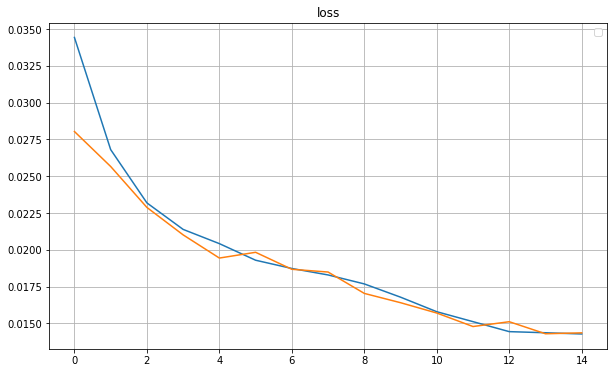

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

313/313 [==============================] - 1s 2ms/step


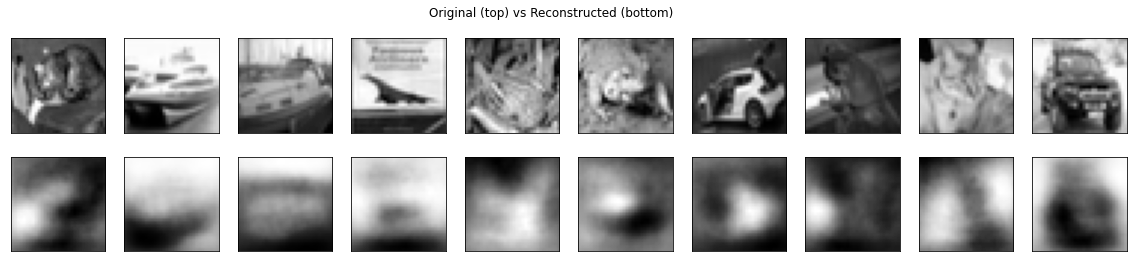

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

### Deep Autoencoder 3

In [ ]:
input_dim = x_train.shape[-1]
input = tf.keras.layers.Input(shape=(input_dim,))
encoder_1 = tf.keras.layers.Dense(input_dim, activation='sigmoid')(input)
encoder_2 = tf.keras.layers.Dense(512, activation='sigmoid')(encoder_1)
encoder_3 = tf.keras.layers.Dense(256, activation='sigmoid')(encoder_2)
encoder_4 = tf.keras.layers.Dense(128, activation='sigmoid')(encoder_3)
encoded = tf.keras.layers.Dense(64, activation='linear')(encoder_4)
decoder_1 = tf.keras.layers.Dense(128, activation='sigmoid')(encoded)
decoder_2 = tf.keras.layers.Dense(256, activation='sigmoid')(decoder_1)
decoder_3 = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder_2)
decoder_4 = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder_3)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder_4)
autoencoder = tf.keras.models.Model(input, decoded) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')


In [ ]:
input_dim

1024

In [ ]:
autoencoder.summary()

Model: "model_798"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_537 (InputLayer)      [(None, 1024)]            0         
                                                                 
 dense_602 (Dense)           (None, 1024)              1049600   
                                                                 
 dense_603 (Dense)           (None, 512)               524800    
                                                                 
 dense_604 (Dense)           (None, 256)               131328    
                                                                 
 dense_605 (Dense)           (None, 128)               32896     
                                                                 
 dense_606 (Dense)           (None, 64)                8256      
                                                                 
 dense_607 (Dense)           (None, 128)               83

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 128, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
313/313 [==============================] - 2s 6ms/step - loss: 0.0567 - val_loss: 0.0569
Epoch 2/15
313/313 [==============================] - 1s 5ms/step - loss: 0.0563 - val_loss: 0.0569
Epoch 3/15
313/313 [==============================] - 2s 5ms/step - loss: 0.0563 - val_loss: 0.0569
Epoch 4/15
313/313 [==============================] - 2s 5ms/step - loss: 0.0563 - val_loss: 0.0569
Epoch 5/15
313/313 [==============================] - 1s 5ms/step - loss: 0.0563 - val_loss: 0.0569
Epoch 6/15
313/313 [==============================] - 1s 5ms/step - loss: 0.0563 - val_loss: 0.0569
Epoch 7/15
313/313 [==============================] - 2s 5ms/step - loss: 0.0563 - val_loss: 0.0569
Epoch 8/15
313/313 [==============================] - 1s 5ms/step - loss: 0.0563 - val_loss: 0.0569
Epoch 9/15
313/313 [==============================] - 1s 5ms/step - loss: 0.0563 - val_loss: 0.0569
Epoch 10/15
313/313 [==============================] - 1s 5ms/step - loss: 0.0563 - val_loss: 0.0569

313/313 - 1s - loss: 0.0562 - 609ms/epoch - 2ms/step
test mse: 0.05623


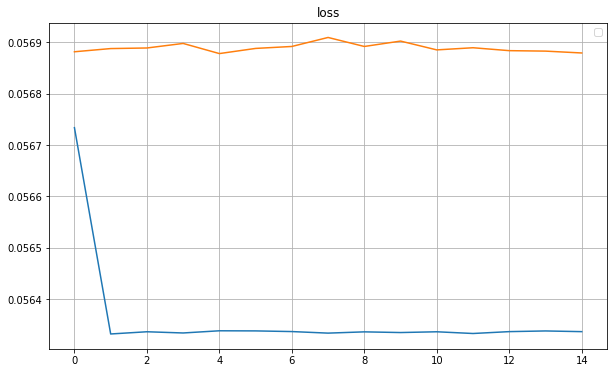

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

313/313 [==============================] - 1s 2ms/step


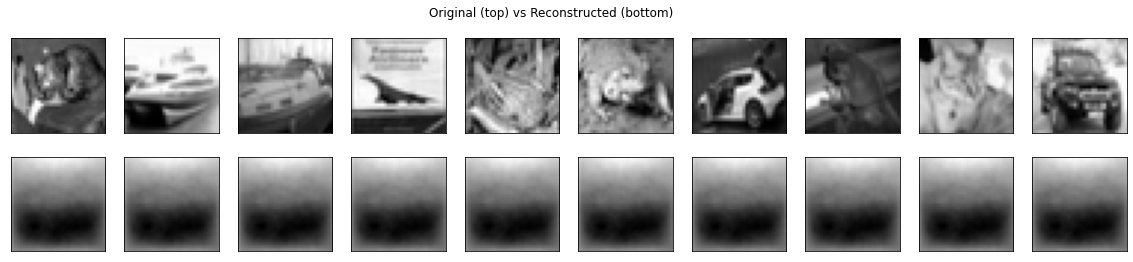

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

### Deep Autoencoder 4

In [16]:
input_dim = x_train.shape[-1]
input_img = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoded = tf.keras.layers.Dense(64, activation='sigmoid')(encoder)
decoder = tf.keras.layers.Dense(128, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoder)
autoencoder = tf.keras.models.Model(input_img, decoded) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [17]:
input_dim

1024

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_4 (Dense)             (None, 128)               131200    
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dense_7 (Dense)             (None, 1024)              132096    
                                                                 
Total params: 279,872
Trainable params: 279,872
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 128, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
313/313 [==============================] - 4s 5ms/step - loss: 0.0257 - val_loss: 0.0193
Epoch 2/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0181 - val_loss: 0.0178
Epoch 3/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 4/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0151 - val_loss: 0.0145
Epoch 5/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 6/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 7/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0135 - val_loss: 0.0141
Epoch 8/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0132
Epoch 9/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0130 - val_loss: 0.0137
Epoch 10/15
313/313 [==============================] - 1s 3ms/step - loss: 0.0129 - val_loss: 0.0129

313/313 - 1s - loss: 0.0129 - 505ms/epoch - 2ms/step
test mse: 0.01295


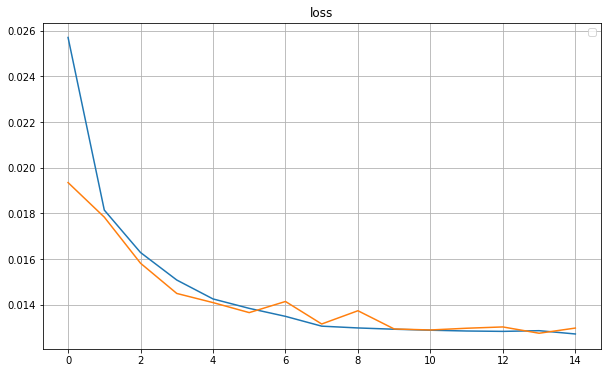

In [20]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

313/313 [==============================] - 1s 1ms/step


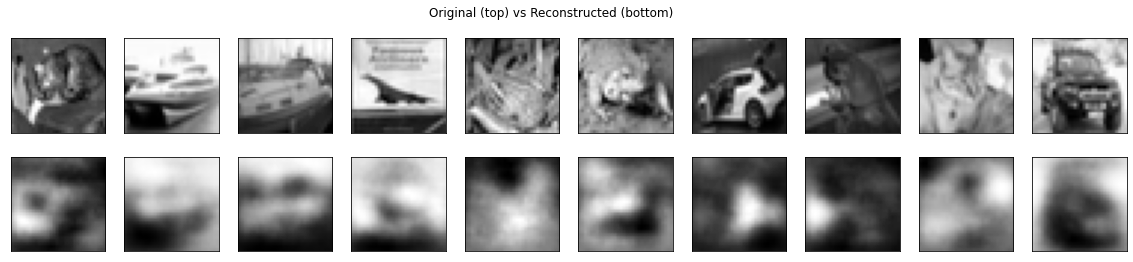

In [21]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [ ]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

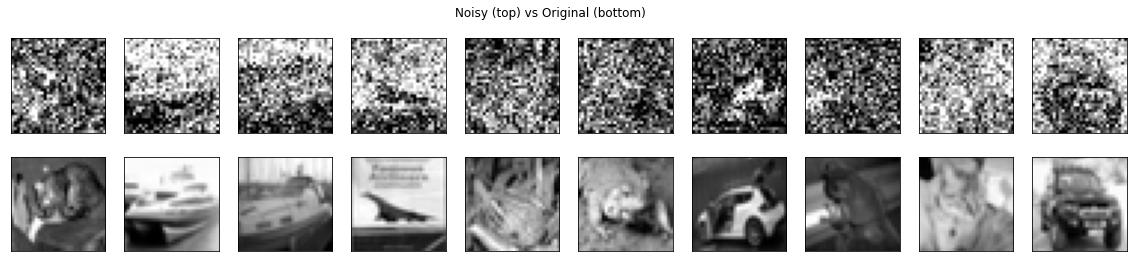

In [ ]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [ ]:
INPUT_DIM = x_train.shape[-1]
ENCODING_DIM = 256 

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse') #[TO COMPLETE]

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dense_1 (Dense)             (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=70, batch_size= 512, shuffle=True, validation_data=(x_valid_noisy, x_valid)) #[TO COMPLETE]

Epoch 1/70
79/79 [==============================] - 3s 9ms/step - loss: 0.0387 - val_loss: 0.0268
Epoch 2/70
79/79 [==============================] - 0s 5ms/step - loss: 0.0233 - val_loss: 0.0226
Epoch 3/70
79/79 [==============================] - 0s 6ms/step - loss: 0.0185 - val_loss: 0.0172
Epoch 4/70
79/79 [==============================] - 1s 6ms/step - loss: 0.0169 - val_loss: 0.0153
Epoch 5/70
79/79 [==============================] - 0s 6ms/step - loss: 0.0163 - val_loss: 0.0145
Epoch 6/70
79/79 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.0142
Epoch 7/70
79/79 [==============================] - 1s 7ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 8/70
79/79 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.0130
Epoch 9/70
79/79 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0151
Epoch 10/70
79/79 [==============================] - 1s 7ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 11/70
79/79 [

313/313 - 1s - loss: 0.0113 - 595ms/epoch - 2ms/step
Test mse: 0.01126


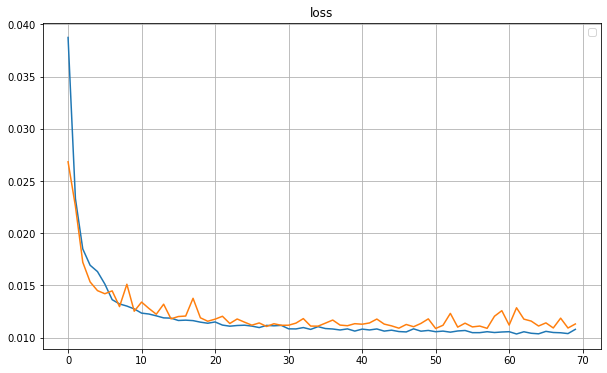

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

313/313 [==============================] - 1s 2ms/step


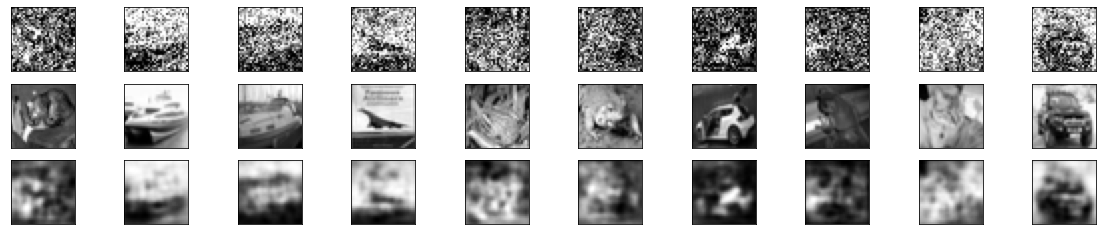

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

### Testing the mse over different noise factors

In [ ]:
mse_train_noised_list = []
mse_test_noised_list = []
ENCODING_DIM = 256 

for noise_factor in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
  x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
  x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

  # we still have to be sure that the color values are in the [0,1] range:
  x_train_noisy = np.clip(x_train_noisy, 0., 1.)
  x_test_noisy = np.clip(x_test_noisy, 0., 1.)
  x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
  #plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

  INPUT_DIM = x_train.shape[-1]
  input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
  encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
  decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)
  autoencoder = tf.keras.models.Model(input_img, decoded)
  autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse') #[TO COMPLETE]
  #autoencoder.summary()
  history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size= 128, shuffle=True, validation_data=(x_valid_noisy, x_valid),verbose = 0) #[TO COMPLETE]
  #plot_loss(history)

  scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
  #print("Test mse: %.5f" % (scores))
  decoded_imgs = autoencoder.predict(x_test_noisy, verbose = 0)
  scores_train = autoencoder.evaluate(x_train_noisy, x_train, verbose=0)

  mse_train_noised_list.append(scores_train)
  mse_test_noised_list.append(scores)

  print("With noise factor %.6f the train mse is %.6f and the test mse is %.6f" %(noise_factor,scores_train,scores))

  #plot_img(10, [x_test_noisy, x_test, decoded_imgs])

With noise factor 0.000000 the train mse is 0.004014 and the test mse is 0.004108
With noise factor 0.100000 the train mse is 0.005288 and the test mse is 0.005460
With noise factor 0.200000 the train mse is 0.008007 and the test mse is 0.008385
With noise factor 0.300000 the train mse is 0.011085 and the test mse is 0.011729
With noise factor 0.400000 the train mse is 0.013087 and the test mse is 0.014160
With noise factor 0.500000 the train mse is 0.016100 and the test mse is 0.017551
With noise factor 0.600000 the train mse is 0.020268 and the test mse is 0.022160
With noise factor 0.700000 the train mse is 0.019575 and the test mse is 0.021331
With noise factor 0.800000 the train mse is 0.020820 and the test mse is 0.023611
With noise factor 0.900000 the train mse is 0.021863 and the test mse is 0.024964
With noise factor 1.000000 the train mse is 0.023226 and the test mse is 0.026745


In [ ]:
mse_train_noised_list

[0.004014344420284033,
 0.005288461223244667,
 0.008007087744772434,
 0.011084863916039467,
 0.013086598366498947,
 0.016100212931632996,
 0.020268186926841736,
 0.019575078040361404,
 0.020820459350943565,
 0.021863173693418503,
 0.023226195946335793]

In [ ]:
mse_test_noised_list

[0.00410789530724287,
 0.0054599931463599205,
 0.008385243825614452,
 0.011729052290320396,
 0.014160295017063618,
 0.01755143702030182,
 0.022160371765494347,
 0.02133128233253956,
 0.023611485958099365,
 0.02496398612856865,
 0.026745157316327095]

Text(0.5, 1.0, 'mse train/test noised')

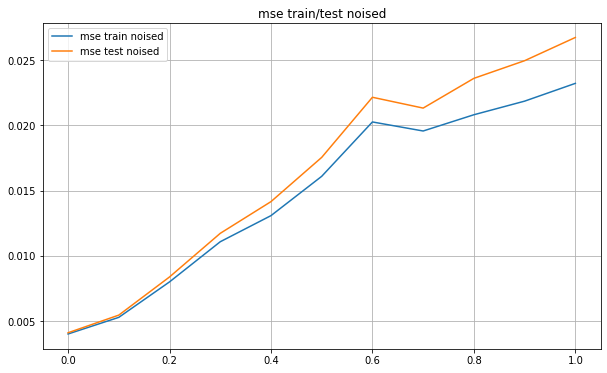

In [ ]:
#fare il plot x=noise_factor, y =mse con due linee una per train e una per test
noise_factor_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
plt.figure(figsize=(10,6))
plt.plot(noise_factor_list, mse_train_noised_list, label = 'mse train noised')
plt.plot(noise_factor_list, mse_test_noised_list, label = 'mse test noised')
plt.legend()
plt.grid()
plt.title('mse train/test noised')

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [74]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [75]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [76]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 90, 50)            7550      
                                                                 
 time_distributed_8 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [77]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 6s 65ms/step - loss: 0.1877 - categorical_accuracy: 0.2415 - val_loss: 0.0875 - val_categorical_accuracy: 0.4054
Epoch 2/50
79/79 [==============================] - 5s 64ms/step - loss: 0.0758 - categorical_accuracy: 0.4552 - val_loss: 0.0708 - val_categorical_accuracy: 0.4674
Epoch 3/50
79/79 [==============================] - 5s 64ms/step - loss: 0.0661 - categorical_accuracy: 0.4874 - val_loss: 0.0639 - val_categorical_accuracy: 0.4935
Epoch 4/50
79/79 [==============================] - 5s 62ms/step - loss: 0.0597 - categorical_accuracy: 0.5165 - val_loss: 0.0580 - val_categorical_accuracy: 0.5184
Epoch 5/50
79/79 [==============================] - 5s 63ms/step - loss: 0.0543 - categorical_accuracy: 0.5474 - val_loss: 0.0538 - val_categorical_accuracy: 0.5696
Epoch 6/50
79/79 [==============================] - 5s 65ms/step - loss: 0.0497 - categorical_accuracy: 0.5762 - val_loss: 0.0486 - val_categorical_accuracy: 0.5883
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0129 - categorical_accuracy: 0.9227 - 335ms/epoch - 8ms/step
categorical_accuracy: 92.27%


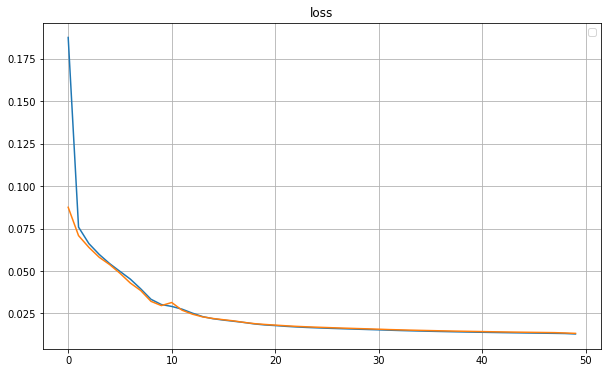

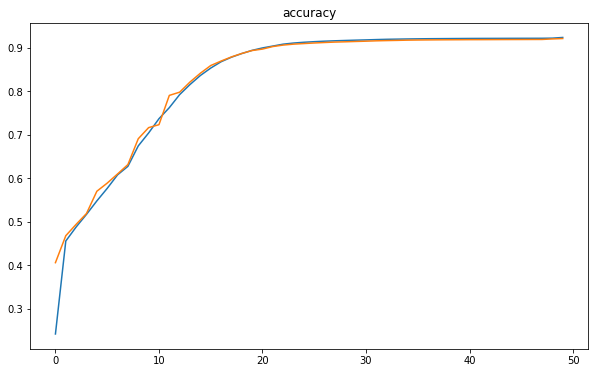

In [78]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [79]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

40/40 [==============================] - 0s 7ms/step
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that have but that <oov> the <oov> is <oov> a do <oov> film in that are <oov> <oov> <oov> <oov> as how other <oov> have <oov> way it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than as <oov> of <oov> <oov> i <oov> it <oov> by of <oov> and i <oov> <oov> on <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

###NLAE for Sequences 1: sigmoid

In [55]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [56]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [57]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(30, return_sequences=True, activation='sigmoid')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='CategoricalCrossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 90, 100)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 90, 30)            15720     
                                                                 
 time_distributed_5 (TimeDis  (None, 90, 100)          3100      
 tributed)                                                       
                                                                 
Total params: 18,820
Trainable params: 18,820
Non-trainable params: 0
_________________________________________________________________


In [58]:
history_sigm = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 13s 155ms/step - loss: 3.7478 - categorical_accuracy: 0.3239 - val_loss: 2.9502 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 12s 148ms/step - loss: 2.8157 - categorical_accuracy: 0.4710 - val_loss: 2.8174 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] - 12s 146ms/step - loss: 2.7454 - categorical_accuracy: 0.4710 - val_loss: 2.7341 - val_categorical_accuracy: 0.4614
Epoch 4/50
79/79 [==============================] - 11s 142ms/step - loss: 2.6231 - categorical_accuracy: 0.4710 - val_loss: 2.5641 - val_categorical_accuracy: 0.4614
Epoch 5/50
79/79 [==============================] - 12s 148ms/step - loss: 2.4130 - categorical_accuracy: 0.4710 - val_loss: 2.3149 - val_categorical_accuracy: 0.4614
Epoch 6/50
79/79 [==============================] - 13s 159ms/step - loss: 2.1409 - categorical_accuracy: 0.4710 - val_loss: 2.0195 - val_categorical_accuracy: 0.461

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0060 - categorical_accuracy: 1.0000 - 498ms/epoch - 12ms/step
categorical_accuracy: 100.00%


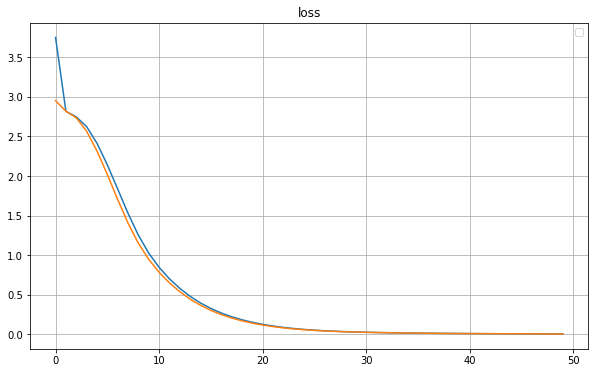

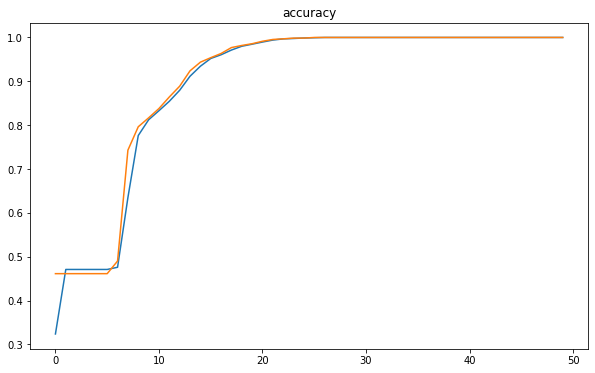

In [59]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history_sigm)

plot_categorical_accuracy(history_sigm)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [60]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

40/40 [==============================] - 1s 12ms/step
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


###NLAE for Sequences 2: tanh

In [61]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [62]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [63]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(30, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='CategoricalCrossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 90, 100)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 90, 30)            15720     
                                                                 
 time_distributed_6 (TimeDis  (None, 90, 100)          3100      
 tributed)                                                       
                                                                 
Total params: 18,820
Trainable params: 18,820
Non-trainable params: 0
_________________________________________________________________


In [64]:
history_tanh = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 3s 18ms/step - loss: 3.6947 - categorical_accuracy: 0.4147 - val_loss: 2.9015 - val_categorical_accuracy: 0.4647
Epoch 2/50
79/79 [==============================] - 1s 11ms/step - loss: 2.7989 - categorical_accuracy: 0.4769 - val_loss: 2.7609 - val_categorical_accuracy: 0.4697
Epoch 3/50
79/79 [==============================] - 1s 11ms/step - loss: 2.6355 - categorical_accuracy: 0.4906 - val_loss: 2.5545 - val_categorical_accuracy: 0.4914
Epoch 4/50
79/79 [==============================] - 1s 12ms/step - loss: 2.4081 - categorical_accuracy: 0.4984 - val_loss: 2.3057 - val_categorical_accuracy: 0.4918
Epoch 5/50
79/79 [==============================] - 1s 12ms/step - loss: 2.1428 - categorical_accuracy: 0.4994 - val_loss: 2.0235 - val_categorical_accuracy: 0.4934
Epoch 6/50
79/79 [==============================] - 1s 13ms/step - loss: 1.8533 - categorical_accuracy: 0.5206 - val_loss: 1.7271 - val_categorical_accuracy: 0.5634
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0047 - categorical_accuracy: 1.0000 - 165ms/epoch - 4ms/step
categorical_accuracy: 100.00%


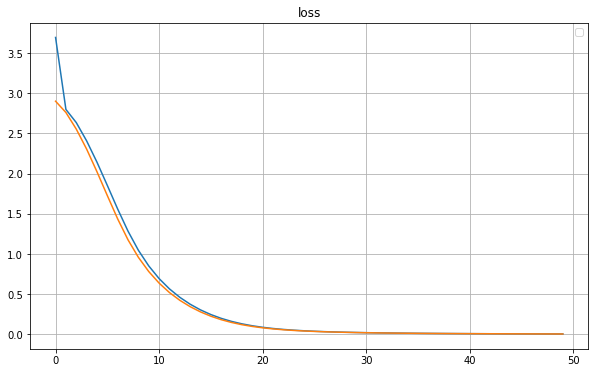

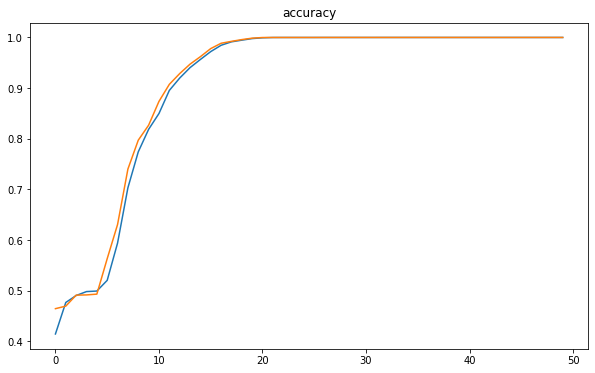

In [65]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history_tanh)

plot_categorical_accuracy(history_tanh)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [66]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

40/40 [==============================] - 0s 3ms/step
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


###NLAE for Sequences 3: relu

In [67]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [68]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [69]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(30, return_sequences=True, activation='relu')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='CategoricalCrossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 lstm_5 (LSTM)               (None, 90, 30)            15720     
                                                                 
 time_distributed_7 (TimeDis  (None, 90, 100)          3100      
 tributed)                                                       
                                                                 
Total params: 18,820
Trainable params: 18,820
Non-trainable params: 0
_________________________________________________________________


In [70]:
history_relu = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 13s 151ms/step - loss: 4.1157 - categorical_accuracy: 0.2560 - val_loss: 3.5394 - val_categorical_accuracy: 0.4716
Epoch 2/50
79/79 [==============================] - 12s 149ms/step - loss: 3.0388 - categorical_accuracy: 0.4756 - val_loss: 2.8174 - val_categorical_accuracy: 0.4678
Epoch 3/50
79/79 [==============================] - 12s 147ms/step - loss: 2.6100 - categorical_accuracy: 0.4919 - val_loss: 2.3638 - val_categorical_accuracy: 0.4921
Epoch 4/50
79/79 [==============================] - 13s 170ms/step - loss: 1.7293 - categorical_accuracy: 0.6098 - val_loss: 1.1633 - val_categorical_accuracy: 0.7463
Epoch 5/50
79/79 [==============================] - 14s 171ms/step - loss: 0.7371 - categorical_accuracy: 0.8515 - val_loss: 0.4493 - val_categorical_accuracy: 0.9290
Epoch 6/50
79/79 [==============================] - 12s 149ms/step - loss: 0.3131 - categorical_accuracy: 0.9534 - val_loss: 0.2337 - val_categorical_accuracy: 0.966

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 1s - loss: 0.0148 - categorical_accuracy: 0.9965 - 536ms/epoch - 13ms/step
categorical_accuracy: 99.65%


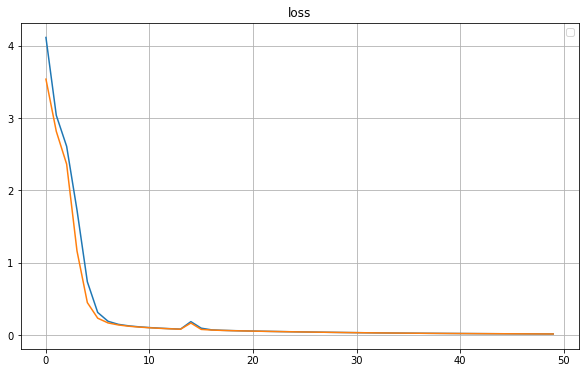

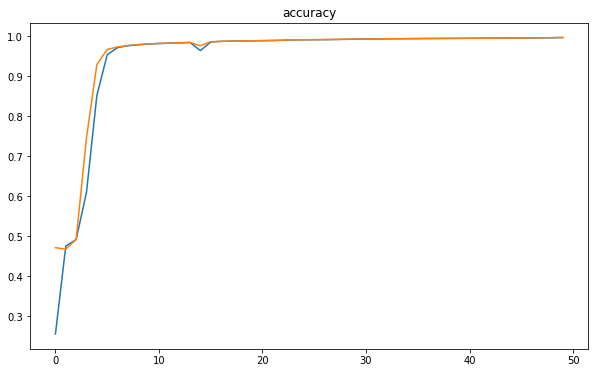

In [71]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history_relu )

plot_categorical_accuracy(history_relu )

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [72]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

40/40 [==============================] - 1s 13ms/step
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
<oov> a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


### Comparison

Text(0.5, 1.0, 'accuracy')

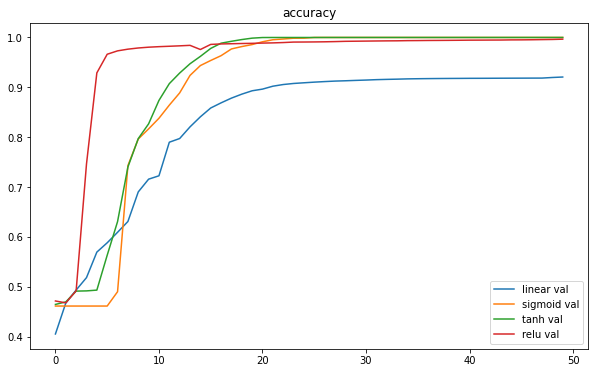

In [80]:
plt.figure(figsize=(10,6))
#plt.plot(history.epoch,history.history['categorical_accuracy'], label = 'linear train')
plt.plot(history.epoch,history.history['val_categorical_accuracy'], label = 'linear val')
#plt.plot(history_sigm.epoch,history_sigm.history['categorical_accuracy'], label = 'sigmoid train')
plt.plot(history_sigm.epoch,history_sigm.history['val_categorical_accuracy'], label = 'sigmoid val')
#plt.plot(history_tanh.epoch,history_tanh.history['categorical_accuracy'], label = 'tanh train')
plt.plot(history_tanh.epoch,history_tanh.history['val_categorical_accuracy'], label = 'tanh val')
#plt.plot(history_relu.epoch,history_relu.history['categorical_accuracy'], label = 'relu train')
plt.plot(history_relu.epoch,history_relu.history['val_categorical_accuracy'], label = 'relu val')
plt.legend()
plt.title('accuracy')

In the plot above we can see the comparison between different activation function (and architecture too). Linear is clearly beaten by the non linear Autoencoders, this was expected since a linear neural network is just equivalent to a linear regression. Now the fact is that relu and sigmoid are quite slower in training and tanh is really faster (15 times faster!); another thing is that relu achives better accuracy in fewer epochs. At the end tanh in the way to go. For the second activation function I always chose the softmax since it is a multi class classification problem.  